In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# For statistical tests
from scipy import stats

from xgboost import XGBClassifier, plot_importance
from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report, confusion_matrix

from bayes_opt import BayesianOptimization

## Load Data

In [26]:
import dask.dataframe as dd # use dask to load dataset which exceeds memory
data = dd.read_csv('./data.csv', dtype={'attributed_time': 'object'})

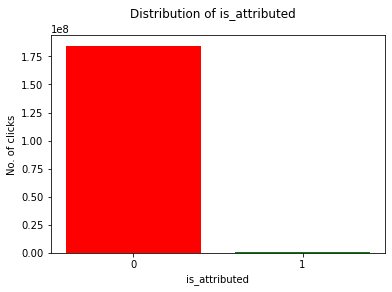

In [16]:
# obtain counts of each class # require 3 mins to load -- show the imbalance
data_0, data_1 = data["is_attributed"].value_counts()

#plot
fig, ax = plt.subplots()
fig.suptitle('Distribution of is_attributed')
labels = ['0', '1']
counts= [data_0, data_1]
ax.set_ylabel('No. of clicks')
ax.set_xlabel("is_attributed")
bars = ax.bar(labels, counts, color = ('red','green'))
plt.show()

We observe that:
1. Dataset is huge, with more than 175 million observations
2. Dataset is highly imbalanced

Thus, following will be the steps for data pre-processing:

1. Random sampling, where the final dataset we will be using will be approximately 0.25 of the size of the current dataset
2. Check for duplicates and remove them (if any)
3. Do train-test split
4. Undersampling on training set to balance the class distribution
5. Deal with missing data (if any)

## Data Pre-processing

### Random Sampling (without replacement)

In [2]:
# Read data by chunks of 10 million observations
# Sample 2.5 million observations randomly without replacement

data = pd.DataFrame()

chunksize = 10**7
with pd.read_csv('./data.csv', chunksize=chunksize) as reader:
  for chunk in reader:
    chunk = chunk.sample(n = int(chunksize/4), replace = False, random_state = 0)
    data = pd.concat([data, chunk])
    print(data.shape)

(2500000, 8)
(5000000, 8)
(7500000, 8)
(10000000, 8)
(12500000, 8)
(15000000, 8)
(17500000, 8)
(20000000, 8)
(22500000, 8)
(25000000, 8)
(27500000, 8)
(30000000, 8)
(32500000, 8)
(35000000, 8)
(37500000, 8)
(40000000, 8)
(42500000, 8)
(45000000, 8)
(47500000, 8)


In [28]:
print(data.shape)
print(data["is_attributed"].value_counts())

(47500000, 8)
0    47383465
1      116535
Name: is_attributed, dtype: int64


### Removing Duplicates

In [3]:
# Check for duplicates
print('Check whether there are duplicates:', data.duplicated().any())
print('Number of duplicates:', sum(data.duplicated(subset=list(data.columns))))

Check whether there are duplicates: True
Number of duplicates: 249747


In [4]:
data = data.drop_duplicates()

print(data.shape)
print(data["is_attributed"].value_counts())

(47250253, 8)
0    47133719
1      116534
Name: is_attributed, dtype: int64


Since attributed_time is only available when is_attributed=1, this feature will not provide much useful information for analytics. Thus, we decided to drop the attributed_time column.

In [5]:
# drop attributed time column
data = data.drop('attributed_time', axis=1)
data.head()

ip  app  device  os  channel           click_time  is_attributed
9487273  159670    2       1  19      435  2017-11-07 00:03:10              0
1409143   81834    6       1   3      125  2017-11-06 16:32:41              0
4861323    2896   12       1  17      245  2017-11-06 20:07:33              0
1226788  140931   64       1  15      459  2017-11-06 16:27:49              0
5698172  121966    1       1   1      134  2017-11-06 21:57:34              0

In [6]:
data.to_csv('./data_sampled.csv', index=False)

### Train-test split

In [33]:
data = pd.read_csv('./data_sampled.csv')

In [7]:
X = data.iloc[:,:-1]
y = data["is_attributed"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print(X_train.shape, X_test.shape)
print(X_train.columns)

(37800202, 6) (9450051, 6)
Index(['ip', 'app', 'device', 'os', 'channel', 'click_time'], dtype='object')


### Save sampled train and test datasets

In [8]:
y_train = pd.DataFrame({'is_attributed': y_train})
y_test = pd.DataFrame({'is_attributed': y_test})

In [9]:
train_sampled = pd.concat([X_train, y_train],  axis=1)
test_sampled = pd.concat([X_test, y_test],  axis=1)
train_sampled.to_csv('./train_sampled.csv', index=False)
test_sampled.to_csv('./test_sampled.csv', index=False)

In [37]:
#Check; can comment out later
train_sampled.head(5)

ip  app  device  os  channel           click_time  is_attributed
46352771  304834   20       1  17      259  2017-11-09 15:58:50              0
40854578   55874    3       1  13      371  2017-11-09 09:24:01              0
657306     55988   12       1  22      259  2017-11-06 16:25:11              0
4681899   204669   15       1  13      245  2017-11-07 00:54:21              0
5771510    68632   14       1  19      401  2017-11-07 03:13:22              0

### Undersampling

In [38]:
def undersample(train):
  train_0 = train[train["is_attributed"] == 0]
  train_1 = train[train["is_attributed"] == 1]

  train_0_count, train_1_count = train["is_attributed"].value_counts()

  # Under-sample class 0
  train_0_under = train_0.sample(n = train_1_count, random_state = 0)

  # Merge undersampled class 0 and original class 1
  train_under = pd.concat([train_0_under, train_1], axis = 0)
  return train_under

In [39]:
train_undersampled = undersample(train_sampled)

print(train_undersampled.shape)
print(train_undersampled["is_attributed"].value_counts())

(186454, 7)
0    93227
1    93227
Name: is_attributed, dtype: int64


In [ ]:
## Save undersampled data
train_undersampled.to_csv('./train_undersampled.csv', index=False)

## (Starting Point) Load Undersampled Train CSV Data

I have run and saved a copy of the unsampled data, I think can just start from here instead of running the undersampling process everytime

In [57]:
train = pd.read_csv('./train_undersampled.csv')
train.head()

ip  app  device  os  channel           click_time  is_attributed
0  116992   15       1  34      245  2017-11-07 06:18:26              0
1   92610    3       1  13      280  2017-11-07 03:06:29              0
2   79894    2       1  19      122  2017-11-07 11:15:24              0
3   32746    3       1  31      480  2017-11-08 14:44:58              0
4    1638    2       1  20      236  2017-11-09 10:24:38              0

In [58]:
train["is_attributed"].value_counts()

0    93227
1    93227
Name: is_attributed, dtype: int64

### Categorical Encoding

In [60]:
## note: should we do categorical encoding here? so we can do EDA?

## adapted from below
import category_encoders as ce

categorical_features = ['ip', 'app', 'device', 'os', 'channel']
#normalize the counts here as the count seems too big which may affect gradient descent?
count_enc = ce.CountEncoder(cols=categorical_features, handle_unknown='value', normalize=True)
new_train_categories = count_enc.fit_transform(train[categorical_features])
new_train_categories.columns = ['ip_enc', 'app_enc', 'device_enc', 'os_enc', 'channel_enc']

train_enc = pd.concat([train, new_train_categories], axis = 1)
train_enc.head()

ip  app  device  os  channel           click_time  is_attributed  \
0  116992   15       1  34      245  2017-11-07 06:18:26              0   
1   92610    3       1  13      280  2017-11-07 03:06:29              0   
2   79894    2       1  19      122  2017-11-07 11:15:24              0   
3   32746    3       1  31      480  2017-11-08 14:44:58              0   
4    1638    2       1  20      236  2017-11-09 10:24:38              0   

     ip_enc   app_enc  device_enc    os_enc  channel_enc  
0  0.000054  0.046462    0.805866  0.001024     0.024338  
1  0.000043  0.101864    0.805866  0.173936     0.043759  
2  0.000016  0.063839    0.805866  0.206887     0.008013  
3  0.000011  0.101864    0.805866  0.002993     0.007825  
4  0.000021  0.063839    0.805866  0.016288     0.004666

In [61]:
plt.figure(figsize=(20, 30))
for index, var in enumerate(train.columns[7:]):
    plt.subplot(5, 2, index+1)
    sns.kdeplot(data=train_enc, x=var, hue="is_attributed", fill=True)
    plt.title(f"Distribution of {var}")

<Figure size 1440x2160 with 0 Axes>

# Exploratory Data Analysis

### 1. Count of unique values of variables

In [25]:
unique_values = []

for x in train.iloc[:,:-1].columns:
  unique_values.append(len(train[x].unique()))

print(len(unique_values))
print(unique_values)

6
[84781, 243, 955, 148, 172, 124815]


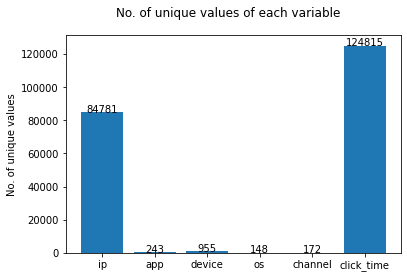

In [26]:
fig, ax = plt.subplots()
fig.suptitle('No. of unique values of each variable')
labels = train.iloc[:,:-1].columns.tolist()

ax.set_ylabel('No. of unique values')
ax.bar(labels, unique_values)

for index, value in enumerate(unique_values):
    ax.text(x = index, y = value, s=str(value), fontdict=dict(fontsize=10), ha="center")

### 1. Distribution of is_attributed



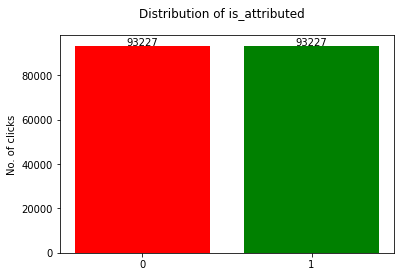

In [27]:
fig, ax = plt.subplots()
fig.suptitle('Distribution of is_attributed')
labels = ['0', '1']

ax.set_ylabel('No. of clicks')
ax.bar(labels, train['is_attributed'].value_counts(), color = ('red','green'))

for index, value in enumerate(train['is_attributed'].value_counts()):
    ax.text(x = index, y = value, s=str(value), fontdict=dict(fontsize=10), ha="center")

### 2. Time of Day for Clicks (in hour)

Extract day, hour, minute, second from click_time

In [62]:
train_datetime = pd.to_datetime(train['click_time'], format='%Y-%m-%d %H:%M:%S')
train['click_time'] = train_datetime
train['day'] = train_datetime.dt.day
train['hour'] = train_datetime.dt.hour
train['minute'] = train_datetime.dt.minute
train['second'] = train_datetime.dt.second

print(train.head())

       ip  app  device  os  channel          click_time  is_attributed  day  \
0  116992   15       1  34      245 2017-11-07 06:18:26              0    7   
1   92610    3       1  13      280 2017-11-07 03:06:29              0    7   
2   79894    2       1  19      122 2017-11-07 11:15:24              0    7   
3   32746    3       1  31      480 2017-11-08 14:44:58              0    8   
4    1638    2       1  20      236 2017-11-09 10:24:38              0    9   

   hour  minute  second  
0     6      18      26  
1     3       6      29  
2    11      15      24  
3    14      44      58  
4    10      24      38  


In [29]:
train_hour_0 = train[train["is_attributed"] == 0]['hour']
train_hour_1 = train[train["is_attributed"] == 1]['hour']

train_min_0 = train[train["is_attributed"] == 0]['minute']
train_min_1 = train[train["is_attributed"] == 1]['minute']

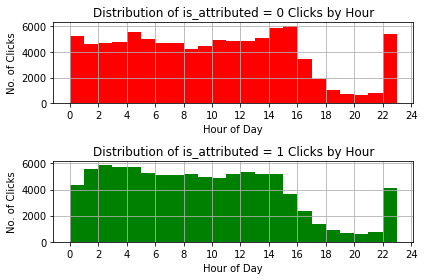

In [30]:
hours = 24 # 24 hours in a day

# Histogram for fraud clicks
plt.subplot(2, 1, 1)
train_hour_0.hist(bins = hours - 1, color = "red")
plt.xlabel("Hour of Day")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 0 Clicks by Hour")
plt.locator_params(axis = "x", nbins = hours)

# Histogram for normal clicks
plt.subplot(2, 1, 2)
train_hour_1.hist(bins = hours - 1, color = "green")
plt.xlabel("Hour of Day")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 1 Clicks by Hour")
plt.locator_params(axis = "x", nbins = hours)

plt.tight_layout()
plt.show()

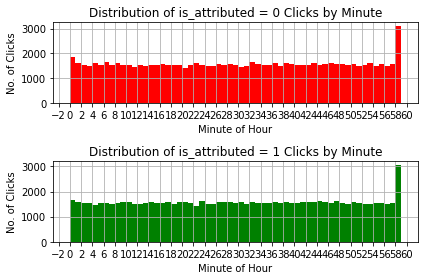

In [31]:
minutes = 60 # 60 minutes in an hour

# Histogram for fraud clicks
plt.subplot(2, 1, 1)
train_min_0.hist(bins = minutes - 1, color = "red")
plt.xlabel("Minute of Hour")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 0 Clicks by Minute")
plt.locator_params(axis = "x", nbins = minutes)

# Histogram for normal clicks
plt.subplot(2, 1, 2)
train_min_1.hist(bins = minutes - 1, color = "green")
plt.xlabel("Minute of Hour")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 1 Clicks by Minute")
plt.locator_params(axis = "x", nbins = minutes)

plt.tight_layout()
plt.show()

### 3. Average Number of Clicks

In [32]:
train_0 = train[train["is_attributed"] == 0]
train_1 = train[train["is_attributed"] == 1]

num_ip_0 = train_0['ip'].nunique()
num_ip_1 = train_1['ip'].nunique()

num_app_0 = train_0['app'].nunique()
num_app_1 = train_1['app'].nunique()

num_clicks_0 = train_0.size
num_clicks_1 = train_1.size

avg_clicks_ip_0 = num_clicks_0 / num_ip_0
avg_clicks_ip_1 = num_clicks_1 / num_ip_1

avg_clicks_app_0 = num_clicks_0 / num_app_0
avg_clicks_app_1 = num_clicks_1 / num_app_1

print(num_ip_0, num_ip_1)
print(num_app_0, num_app_1)

33418 67422
165 174


<BarContainer object of 2 artists>

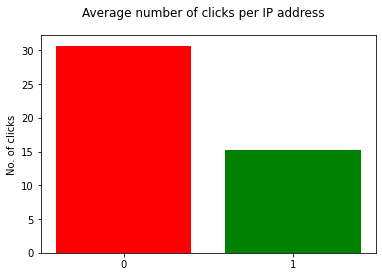

In [33]:
fig, ax = plt.subplots()
fig.suptitle('Average number of clicks per IP address')
labels = ['0', '1']

ax.set_ylabel('No. of clicks')
ax.bar(labels, (avg_clicks_ip_0, avg_clicks_ip_1), color = ('red','green'))

Great difference between the two classes

<BarContainer object of 2 artists>

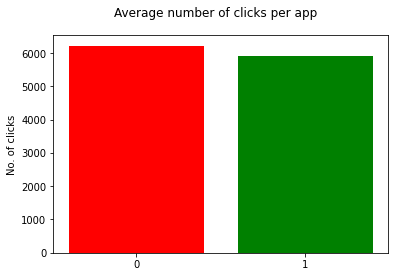

In [34]:
fig, ax = plt.subplots()
fig.suptitle('Average number of clicks per app')
labels = ['0', '1']

ax.set_ylabel('No. of clicks')
ax.bar(labels, (avg_clicks_app_0, avg_clicks_app_1), color = ('red','green'))

### 4. Distribution of Device


In [35]:
fraud_data = train[train["is_attributed"] == 0]
notfraud_data = train[train["is_attributed"] == 1]

In [36]:
device_labels = sorted(train["device"].unique().tolist())
device_fraud = []
device_notfraud = []

for device in device_labels:
  device_fraud.append(len(fraud_data[fraud_data["device"] == device]))
  device_notfraud.append(len(notfraud_data[notfraud_data["device"] == device]))

device_labels = [str(x) for x in device_labels]

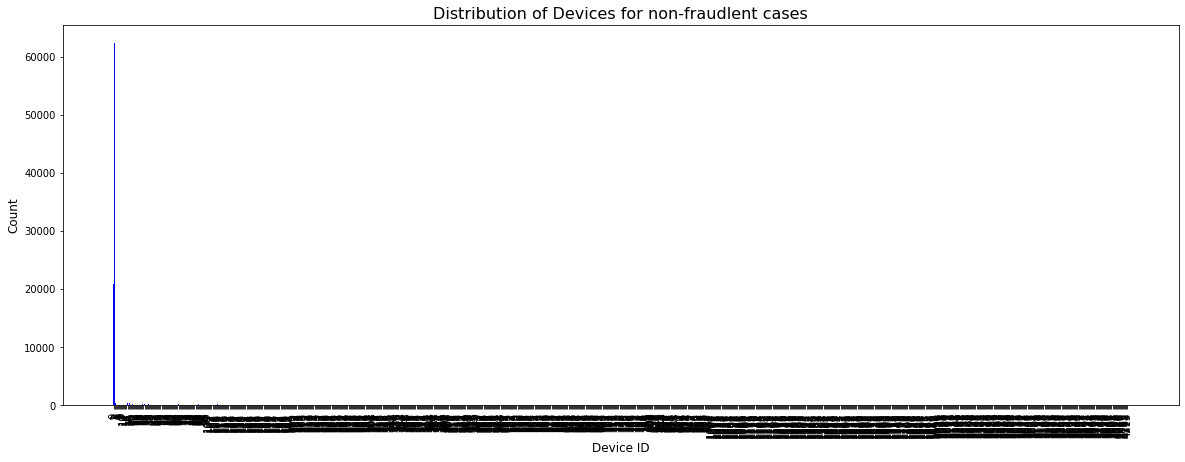

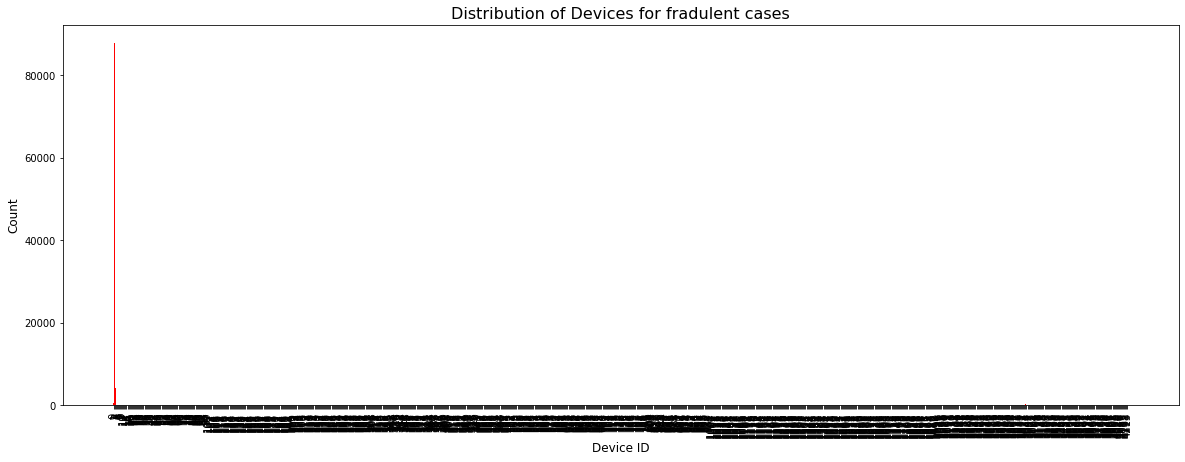

In [37]:
# Not fradulent
plt.figure(figsize = (20, 7))
plt.bar(x = device_labels,
        height = device_notfraud,
        color = "blue")
plt.xticks(rotation = 90)
plt.title("Distribution of Devices for non-fraudlent cases", fontsize = 16) 
plt.xlabel("Device ID", fontsize = 12)

  # Option 1: Using normal scale  
plt.ylabel("Count", fontsize = 12)

  # Option 2: Using log scale
# plt.yscale('log')
# plt.ylabel("Log of Count", fontsize = 12)

plt.show()


# Fradulent
plt.figure(figsize = (20, 7))
plt.bar(x = device_labels,
        height = device_fraud,
        color = 'red')
plt.xticks(rotation = 90)
plt.title("Distribution of Devices for fradulent cases", fontsize = 16) 
plt.xlabel("Device ID", fontsize = 12)

  # Option 1: Using normal scale 
plt.ylabel("Count", fontsize = 12)

  # Option 2: Using log scale
# plt.yscale('log')
# plt.ylabel("Log of Count", fontsize = 12)

plt.show()

### 5. Distribution of Channel

In [39]:
channel_labels = sorted(train["channel"].unique().tolist())
channel_fraud = []
channel_notfraud = []

for channel in channel_labels:
  channel_fraud.append(len(fraud_data[fraud_data["channel"] == channel]))
  channel_notfraud.append(len(notfraud_data[notfraud_data["channel"] == channel]))

channel_labels = [str(x) for x in channel_labels]

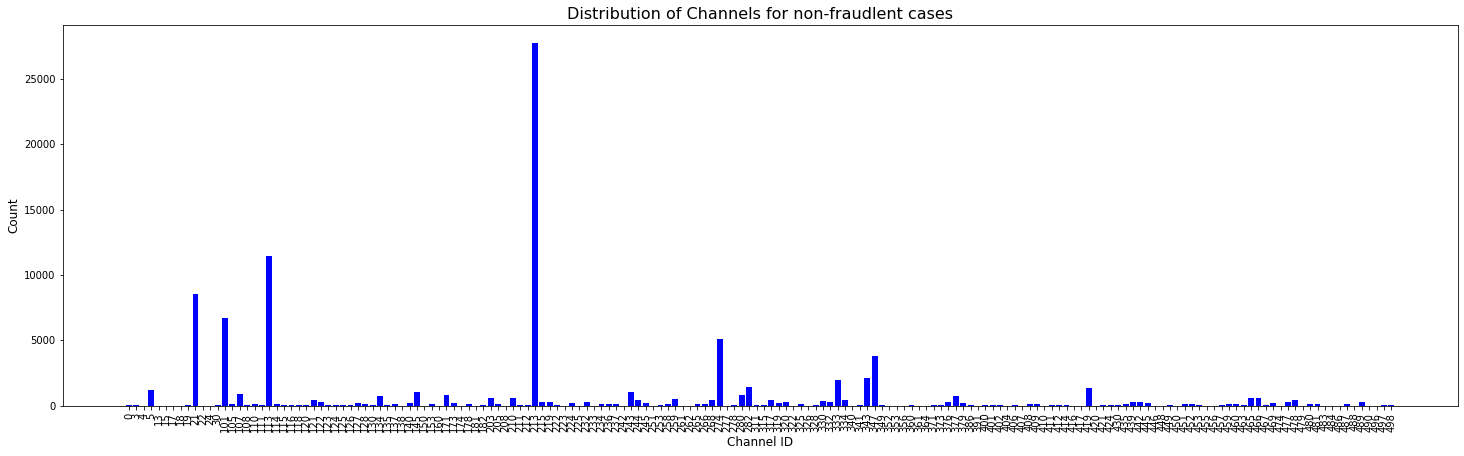

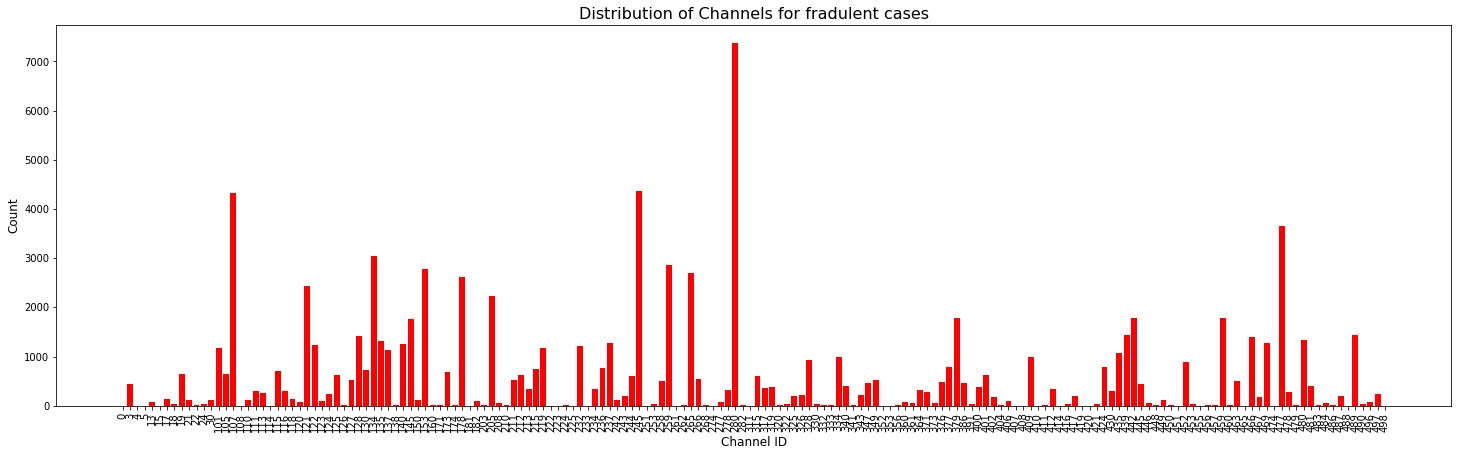

In [40]:
# Not fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = channel_labels,
        height = channel_notfraud,
        color = "blue")
plt.xticks(rotation = 90)
plt.title("Distribution of Channels for non-fraudlent cases", fontsize = 16) 
plt.xlabel("Channel ID", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

# Fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = channel_labels,
        height = channel_fraud,
        color = 'red')
plt.xticks(rotation = 90)
plt.title("Distribution of Channels for fradulent cases", fontsize = 16) 
plt.xlabel("Channel ID", fontsize = 12)
plt.ylabel("Count", fontsize = 12)

plt.show()

### 6. Distribution of IP

In [42]:
ip_labels = sorted(train["ip"].unique().tolist())
ip_fraud = []
ip_notfraud = []

for ip in ip_labels:
  ip_fraud.append(len(fraud_data[fraud_data["ip"] == ip]))
  ip_notfraud.append(len(notfraud_data[notfraud_data["ip"] == ip]))

ip_labels = [str(x) for x in ip_labels]

In [ ]:
# Not fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = ip_labels,
        height = ip_notfraud,
        color = "blue")
plt.xticks(rotation = 90)
plt.title("Distribution of IP addresses for non-fraudlent cases", fontsize = 16) 
plt.xlabel("IP Adress", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

# Fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = ip_labels,
        height = ip_fraud,
        color = 'red')
plt.xticks(rotation = 90)
plt.title("Distribution of IP addresses for fradulent cases", fontsize = 16) 
plt.xlabel("Channel ID", fontsize = 12)
plt.ylabel("Count", fontsize = 12)

plt.show()

In [ ]:
# For checks
print("IP Labels are: ", "\n", ip_labels)
print("Non fradulent counts are: ", "\n", ip_fraud)
print("Fradulent counts are: ", "\n", ip_notfraud)

### 7. Distribution of OS

In [ ]:
plt.figure(figsize=(20, 15))
ax = sns.countplot(x="os", hue="is_attributed", data=train)
ax.set_yscale("log")
ax.legend(loc="upper right")
# generate graph xlabels
attributed_os = train[train["is_attributed"]==1]["os"].unique()
os_xlabels = [str(i) if i in attributed_os else "" for i in sorted(train["os"].unique())]
ax.set_xticklabels(os_xlabels, fontsize=8)
ax.set_title("Distribution of OS")
plt.show()

In [44]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'conversion_rate']
merge

os  click_count  conversion_rate
0     19        38575         0.421854
1     13        32431         0.383183
2     24         9999         0.983598
3      0         7944         0.979481
4     17         7309         0.319469
..   ...          ...              ...
143  136            1         0.000000
144  117            1         0.000000
145  131            1         1.000000
146  122            1         0.000000
147  103            1         0.000000

[148 rows x 3 columns]

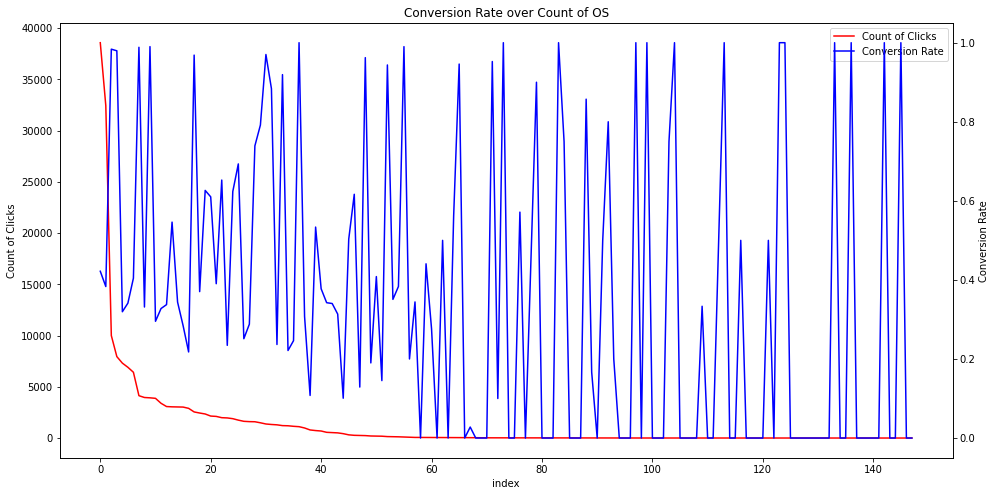

In [45]:
fig,ax = plt.subplots(figsize=(16, 8))

l1 = ax.plot(merge.click_count, color="red", label="Count of Clicks")
#ax.set_yscale("log")
ax.set_ylabel("Count of Clicks")

ax2=ax.twinx()
l2 = ax2.plot(merge.conversion_rate, color="blue", label="Conversion Rate")
ax2.set_ylabel("Conversion Rate")

lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="best")
ax.set_xlabel("index")
ax.set_title("Conversion Rate over Count of OS")
plt.show()

### 8. Average Time between Clicks

In [5]:
from datetime import datetime

sorted_ip = sorted(train["ip"].unique())
sorted_ip_attributed = sorted(train[train["is_attributed"]==1]["ip"].unique())
click_average_time_0 = []
click_average_time_1 = []

def get_average_time(click_time):
  count = len(click_time)
  # assign -1 if click once
  if count <= 1:
    return -1
  else:
    start_time = datetime.strptime(click_time[0], '%Y-%m-%d %H:%M:%S')
    end_time = datetime.strptime(click_time[count-1], '%Y-%m-%d %H:%M:%S')
    difference = (end_time - start_time).total_seconds()/60
    if difference == 0:
      return 0
    else:
      return difference/(count-1)

for ip in sorted_ip:
  click_time = sorted(train[train["ip"]==ip]["click_time"].values)
  average_time = get_average_time(click_time)
  # remove -1 values for better visualization
  if average_time != -1:
    if ip in sorted_ip_attributed:
      click_average_time_1.append(average_time)
    else:
      click_average_time_0.append(average_time)


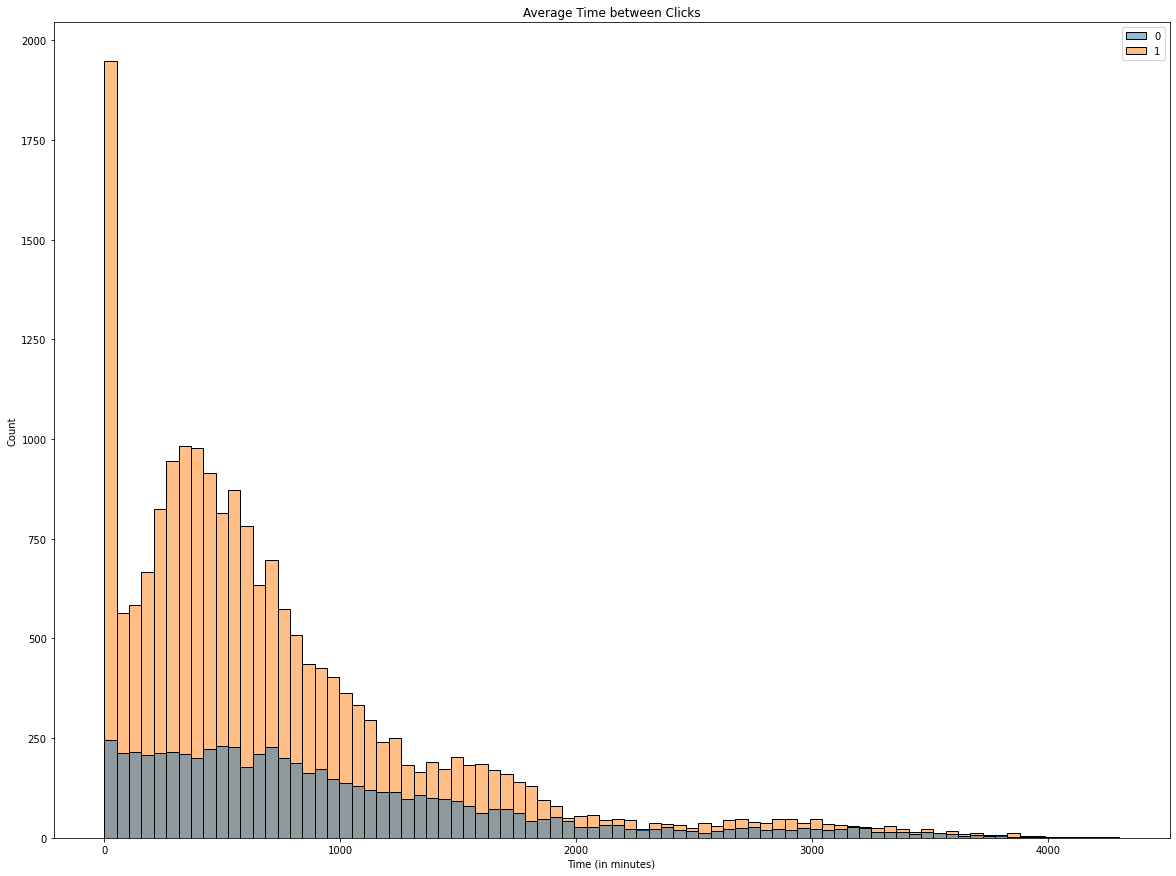

In [20]:
click_average.head()
plt.figure(figsize=(20, 15))
ax = sns.histplot([click_average_time_0, click_average_time_1], multiple = "layer")
ax.set_xlabel("Time (in minutes)")
ax.set_title("Average Time between Clicks")
plt.show()

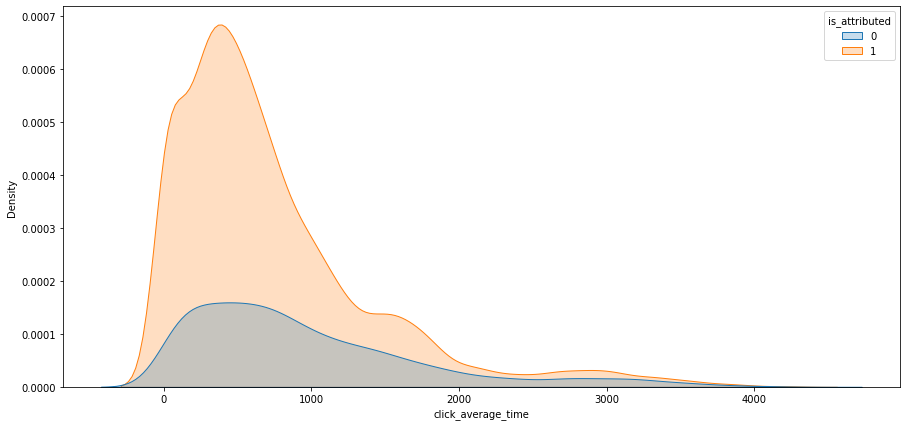

In [22]:
click_average = pd.DataFrame({'click_average_time': click_average_time_0 + click_average_time_1,
                              'is_attributed': [0] * len(click_average_time_0) + [1] * len(click_average_time_1)
                             })
plt.figure(figsize=(15, 7))
sns.kdeplot(data=click_average, x='click_average_time', hue="is_attributed", fill=True)
plt.show()

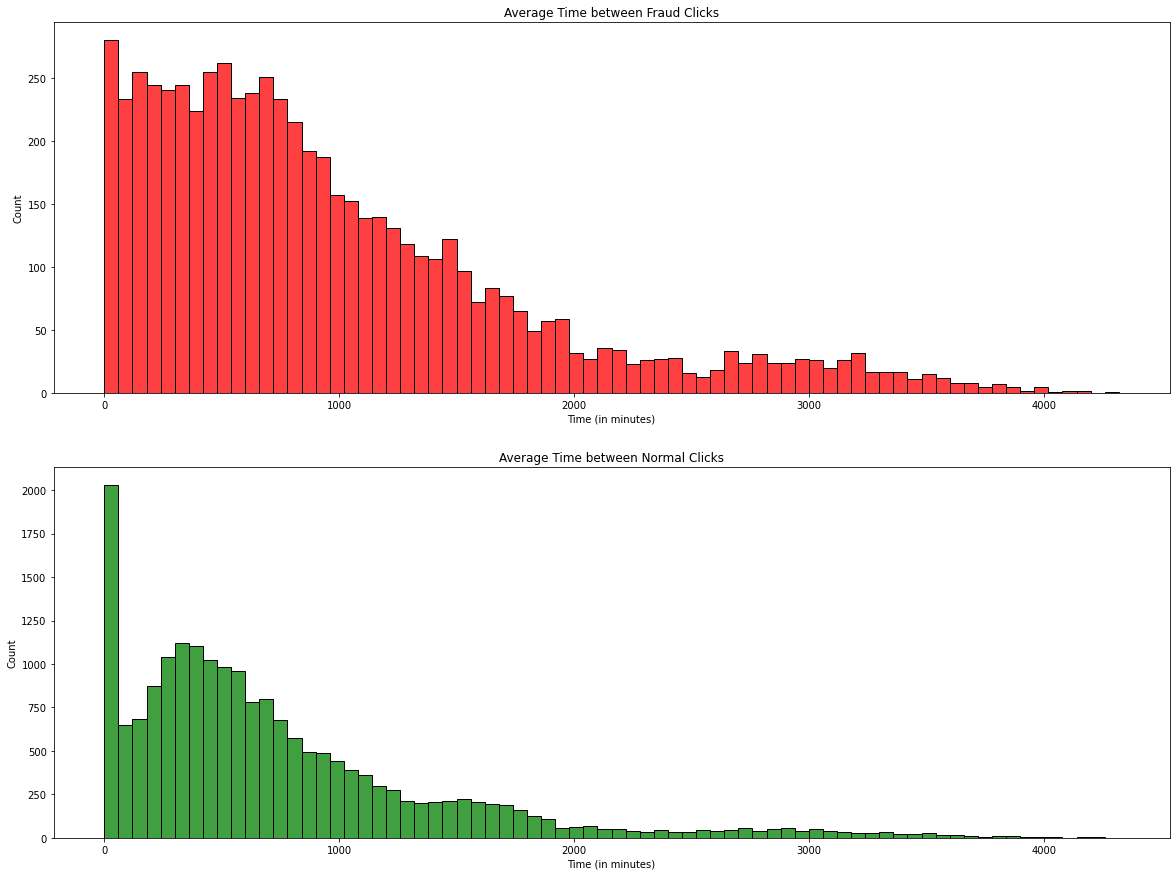

In [7]:
rng = range(int(min(click_average_time_0)), int(max(click_average_time_0)) + 60, 60)

fig, axes = plt.subplots(2, 1, figsize=(20, 15))
# Histogram for fraud clicks
sns.histplot(click_average_time_0, ax = axes[0], bins = rng, color = "red")
axes[0].set_xlabel("Time (in minutes)")
axes[0].set_title("Average Time between Fraud Clicks")

# Histogram for normal clicks
sns.histplot(click_average_time_1, ax = axes[1], bins = rng, color = "green")
axes[1].set_xlabel("Time (in minutes)")
axes[1].set_title("Average Time between Normal Clicks")

plt.show()

### 10. Conversion Rate between clicky IP and non clicky IP

In [23]:
#work with categorical varibles
categorical = train[["ip", "app", "device", "os", "channel", "is_attributed"]].apply(lambda x: x.astype("category"))
categorical.is_attributed = categorical.is_attributed.astype(int)
categorical.is_attributed.value_counts()

0    93227
1    93227
Name: is_attributed, dtype: int64

In [24]:
#each ip can have multiple clicks
train["ip"].value_counts()

5348      1122
5314      1109
73487      610
73516      589
53454      302
          ... 
318551       1
207538       1
45349        1
187707       1
5604         1
Name: ip, Length: 84781, dtype: int64

In [25]:
#conversion rate just by looking at ip
#can have multiple downloads per ip
agg_func_count = {"is_attributed": ["count", "sum"]}
x = train.groupby(["ip"]).agg(agg_func_count)
x.columns = ["clicks", "downloads"]
x = x.sort_values('clicks', ascending=False).reset_index()
x["conversion_rate"] = x.downloads/x.clicks
x.head()

ip  clicks  downloads  conversion_rate
0   5348    1122        492         0.438503
1   5314    1109        481         0.433724
2  73487     610        239         0.391803
3  73516     589        204         0.346350
4  53454     302         29         0.096026

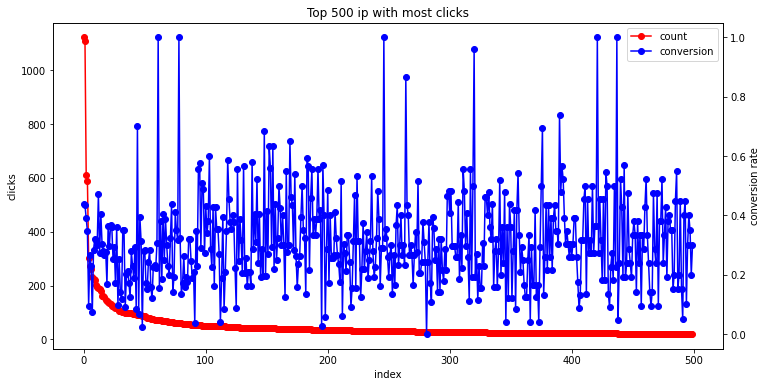

In [26]:
#comparing clicks and conversion rate for top 500 ip addresses
#whether there is download seem pretty random, does not really seem to be related to ip
fig,ax = plt.subplots(figsize=(12,6))

l1 = ax.plot(x.clicks[:500], color="red", marker="o", label="count")
ax.set_ylabel("clicks")

ax2=ax.twinx()
l2 = ax2.plot(x.conversion_rate[:500], color="blue", marker="o", label="conversion")
ax2.set_ylabel("conversion rate")

lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="best")
ax.set_xlabel("index")
ax.set_title("Top 500 ip with most clicks")
plt.show()

### 11. Channel and Conversion Rate

In [29]:
train['click_date'] = train_datetime.dt.date
train['dateTime'] = pd.to_datetime(train.click_date) + pd.to_timedelta(train.hour, unit='h')
train_isAttributed = train[train['is_attributed'] == 1]

In [30]:
number_click_channel = pd.DataFrame(train.groupby(by=["channel"]).size()).reset_index()
number_click_channel = number_click_channel.rename({0: 'count'}, axis=1)
number_click_channel.rename(columns={'count':'number_click'}, inplace=True)

number_download_channel = pd.DataFrame(train_isAttributed.groupby(by=["channel"]).size()).reset_index()
number_download_channel = number_download_channel.rename({0: 'count'}, axis=1)
number_download_channel.rename(columns={'count':'number_download'}, inplace=True)

conversion_rate_channel = number_click_channel.join(number_download_channel.set_index('channel'), on="channel")
conversion_rate_channel['number_download'] = conversion_rate_channel['number_download'].fillna(0)
conversion_rate_channel['conversion_rate'] = conversion_rate_channel['number_download']/conversion_rate_channel['number_click']

In [31]:
conversion_rate_channel.head(5)

channel  number_click  number_download  conversion_rate
0        0            32             31.0         0.968750
1        3           523             78.0         0.149140
2        4            12             12.0         1.000000
3        5          1166           1164.0         0.998285
4       13            83              3.0         0.036145

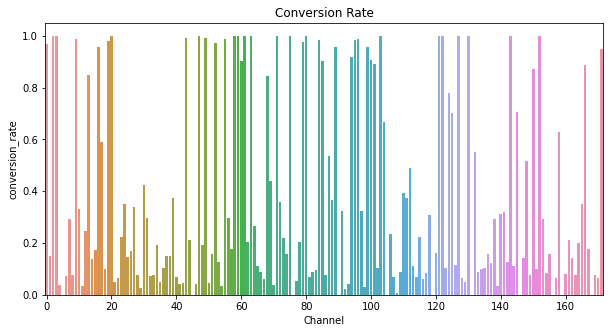

In [32]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=conversion_rate_channel, x='channel', y='conversion_rate')
ax.set_xlabel("Channel")
ax.set_title("Conversion Rate")
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

### 12. Device and Conversion Rate

In [33]:
number_click_device = pd.DataFrame(train.groupby(by=["device"]).size()).reset_index()
number_click_device = number_click_device.rename({0: 'count'}, axis=1)
number_click_device.rename(columns={'count':'number_click'}, inplace=True)

number_download_device = pd.DataFrame(train_isAttributed.groupby(by=["device"]).size()).reset_index()
number_download_device = number_download_device.rename({0: 'count'}, axis=1)
number_download_device.rename(columns={'count':'number_download'}, inplace=True)

conversion_rate_device = number_click_device.join(number_download_device.set_index('device'), on="device")
conversion_rate_device['number_download'] = conversion_rate_device['number_download'].fillna(0)
conversion_rate_device['conversion_rate'] = conversion_rate_device['number_download']/conversion_rate_device['number_click']

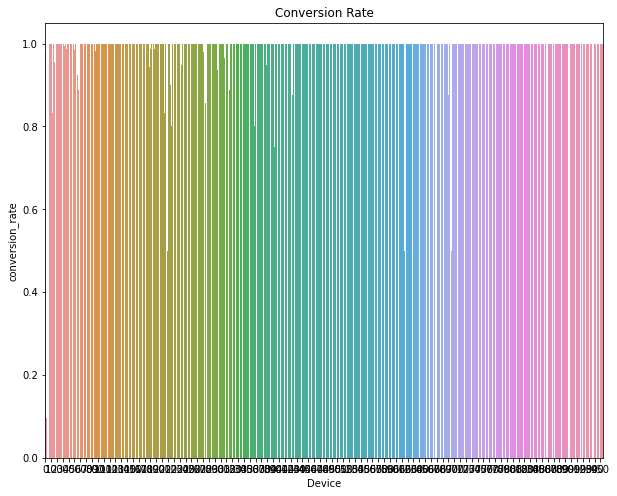

In [34]:
plt.figure(figsize=(10,8))
ax = sns.barplot(data=conversion_rate_device, x='device', y='conversion_rate')
ax.set_xlabel("Device")
ax.set_title("Conversion Rate")
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

### 13. Click and Conversion Rate throughout the day

In [35]:
number_click_time = pd.DataFrame(train.groupby(by=["dateTime"]).size()).reset_index()
number_click_time = number_click_time.rename({0: 'count'}, axis=1)
number_click_time.rename(columns={'count':'number_click'}, inplace=True)

number_download_time= pd.DataFrame(train_isAttributed.groupby(by=["dateTime"]).size()).reset_index()
number_download_time = number_download_time.rename({0: 'count'}, axis=1)
number_download_time.rename(columns={'count':'number_download'}, inplace=True)

conversion_rate_time = number_click_time.join(number_download_time.set_index('dateTime'), on="dateTime")
conversion_rate_time['number_download'] = conversion_rate_time['number_download'].fillna(0)
conversion_rate_time['conversion_rate'] = conversion_rate_time['number_download']/conversion_rate_time['number_click']
conversion_rate_time = conversion_rate_time.set_index('dateTime')

/var/folders/tz/3bpf14pn36z72d11bmhk0zp00000gn/T/ipykernel_2028/2274248138.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(conversion_rate_time.index, rotation=-80)


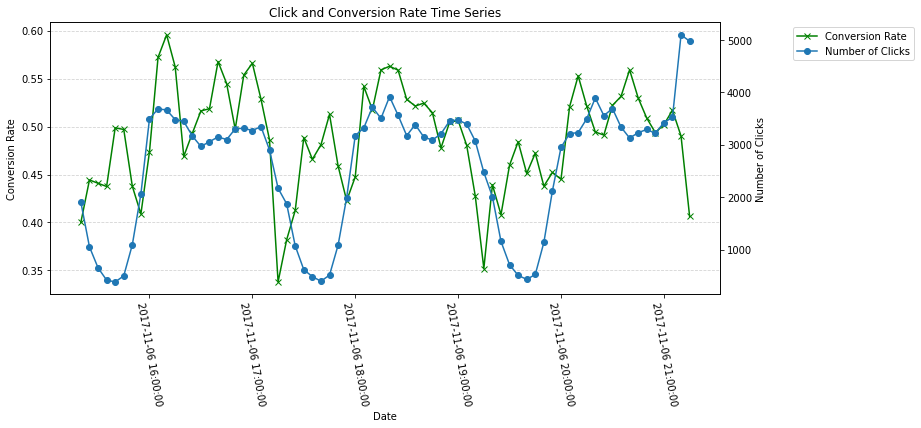

In [36]:
# setting figure size to 12, 10
fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()
# Labelling the axes and setting
# a title
ax.set_xlabel("Date")
ax.set_ylabel("Conversion Rate")
ax2.set_ylabel("Number of Clicks")
ax.set_title("Click and Conversion Rate Time Series")

# plotting the "A" column alone
p1, = ax.plot(conversion_rate_time['conversion_rate'],  color='green', marker='x', label='Conversion Rate')
p2, = ax2.plot(conversion_rate_time['number_click'], marker='o', label="Number of Clicks")
ax.set_xticklabels(conversion_rate_time.index, rotation=-80)
plt.legend(handles=[p1,p2],bbox_to_anchor=(1.2, 1), loc='upper center')
ax.yaxis.grid(color='lightgray', linestyle='dashed')
ax2.yaxis.grid(False)
plt.show()

#  Feature Engineering

### Different combination/aggregation of features

In [63]:
#functions to help aggregate and count

#total counts
def agg_counts(df, group_cols, name):
  grp = df.groupby(group_cols).size().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df


#unique counts
def agg_unique(df, group_cols, unique_col, name):
  grp = df.groupby(group_cols)[unique_col].nunique().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df


#cumulative counts
def agg_cum_count(df, group_cols, name):
  grp = df.groupby(group_cols).cumcount()
  df[name] = grp.values
  return df

#variance
def agg_var(df, group_cols, counted, name):
    grp = df.groupby(group_cols)[counted].var().rename(name).to_frame().reset_index()
    df = df.merge(grp, on=group_cols, how='left')
    return df

#mean
def agg_mean(df, group_cols, counted, name):
    grp = df.groupby(group_cols)[counted].mean().rename(name).to_frame().reset_index()
    df = df.merge(grp, on=group_cols, how='left')
    return df

In [64]:
#data to do combi on 
train_agg = train.copy()
train_agg["dayOfWeek"] = train_agg["click_time"].dt.weekday
train_agg.head()

ip  app  device  os  channel          click_time  is_attributed  day  \
0  116992   15       1  34      245 2017-11-07 06:18:26              0    7   
1   92610    3       1  13      280 2017-11-07 03:06:29              0    7   
2   79894    2       1  19      122 2017-11-07 11:15:24              0    7   
3   32746    3       1  31      480 2017-11-08 14:44:58              0    8   
4    1638    2       1  20      236 2017-11-09 10:24:38              0    9   

   hour  minute  second  dayOfWeek  
0     6      18      26          1  
1     3       6      29          1  
2    11      15      24          1  
3    14      44      58          2  
4    10      24      38          3

In [65]:
#try some combinations, to see if there is a relationship
#total counts
train_agg = agg_counts(train_agg, ["ip", "app", "device", "os", "channel"], 'ip_app_dev_os_cha_counts')
train_agg = agg_counts(train_agg, ["ip", "app", "device", "os"], 'ip_app_dev_os_counts')
train_agg = agg_counts(train_agg, ["ip", "app", "device"], 'ip_app_dev_counts')
train_agg = agg_counts(train_agg, ["ip", "app", "os"], 'ip_app_os_counts')
train_agg = agg_counts(train_agg, ["ip", "app", "hour"], 'ip_app_hour_counts')
train_agg = agg_counts(train_agg, ["ip", "channel"], 'ip_channel_counts')
train_agg = agg_counts(train_agg, ["ip", "app"], 'ip_app_counts')
train_agg = agg_counts(train_agg, ["ip", "day"], 'ip_per_day')
train_agg = agg_counts(train_agg, ["ip"], "ip_counts")

In [66]:
#unique counts
train_agg = agg_unique(train_agg, ["ip"], "app", "uniq_app_per_ip")
train_agg = agg_unique(train_agg, ["ip"], "device", "uniq_device_per_ip")
train_agg = agg_unique(train_agg, ["ip"], "channel", "uniq_channel_per_ip")
train_agg = agg_unique(train_agg, ["ip"], "os", "uniq_os_per_ip")
train_agg = agg_unique(train_agg, ["ip", "device", "os"], "app", "uniq_app_per_ip_dev_os")
train_agg = agg_unique(train_agg, ["app"], "channel", "uniq_channel_per_app")
train_agg = agg_unique(train_agg, ["ip", "day"], "hour", "uniq_hour_per_ip_day")
train_agg = agg_unique(train_agg, ["ip", "app"], "os", "uniq_os_per_ip_app")

In [67]:
#cumulative counts
train_agg = agg_cum_count(train_agg, ["ip"], "cum_count_by_ip")
train_agg = agg_cum_count(train_agg, ["ip", "device"], "cum_count_by_ip_device")
train_agg = agg_cum_count(train_agg, ["ip", "device","os"], "cum_count_by_ip_device_os")
train_agg = agg_cum_count(train_agg, ["ip", "device","os","channel"], "cum_count_by_ip_device_os_channel")
train_agg = agg_cum_count(train_agg, ["ip", "device","os","channel","app"], "cum_count_by_ip_device_os_channel_app")
train_agg = agg_cum_count(train_agg, ["app"], "cum_count_by_app")
train_agg = agg_cum_count(train_agg, ["ip", "app"], "cum_count_by_ip_app")

In [68]:
#variance
train_agg = agg_var(train_agg, ["ip","app","channel"], "hour", "var_hour_by_ip_app_channel")
train_agg = agg_var(train_agg, ["ip","app","os"], "hour", "var_hour_by_ip_app_os")
train_agg = agg_var(train_agg, ["ip","app","device"], "hour", "var_hour_by_ip_app_device")
train_agg = agg_var(train_agg, ["ip","app","channel"], "dayOfWeek", "var_day_by_ip_app_channel")
train_agg = agg_var(train_agg, ["ip","app","os"], "dayOfWeek", "var_day_by_ip_app_os")
train_agg = agg_var(train_agg, ["ip","app","device"], "dayOfWeek", "var_day_by_ip_app_device")

In [69]:
#mean
train_agg = agg_mean(train_agg, ["ip","app","channel"], "hour", "mean_hour_by_ip_app_channel")
train_agg = agg_mean(train_agg, ["ip","app","os"], "hour", "mean_hour_by_ip_app_os")
train_agg = agg_mean(train_agg, ["ip","app","device"], "hour", "mean_hour_by_ip_app_device")

In [51]:
train = train_agg
train.head(5)

ip  app  device  os  channel           click_time  is_attributed
0  116992   15       1  34      245  2017-11-07 06:18:26              0
1   92610    3       1  13      280  2017-11-07 03:06:29              0
2   79894    2       1  19      122  2017-11-07 11:15:24              0
3   32746    3       1  31      480  2017-11-08 14:44:58              0
4    1638    2       1  20      236  2017-11-09 10:24:38              0

In [70]:
#density plots get array of labels
xlab = np.array(train_agg.columns[14:len(train_agg.columns)])

def plot_rbyc(data_plot, xlab_arr, r, c, log = False):
  
  data = data_plot.copy()

  if log == True:
    data[xlab_arr] = np.log10(data_plot[xlab_arr])
    
  fig, axs = plt.subplots(r,c, figsize=(5*c, 2*r))
  row, col = 0, 0
    
  for i in range(0, len(xlab_arr)):
    sns.kdeplot(data=data, x=xlab_arr[i], hue="is_attributed", ax=axs[row,col], fill=True)
    if col == c-1:
      col = 0
      row += 1
    else:
      col +=1

  to_be_empty = r*c - len(xlab_arr)
  while to_be_empty > 0:
      axs[row,col].set_visible(False)
      if col == c-1:
        col = 0
        row += 1
      else:
        col +=1
      to_be_empty -= 1
      
  plt.tight_layout()
  plt.show()


Different combinations of aggregating original features: 



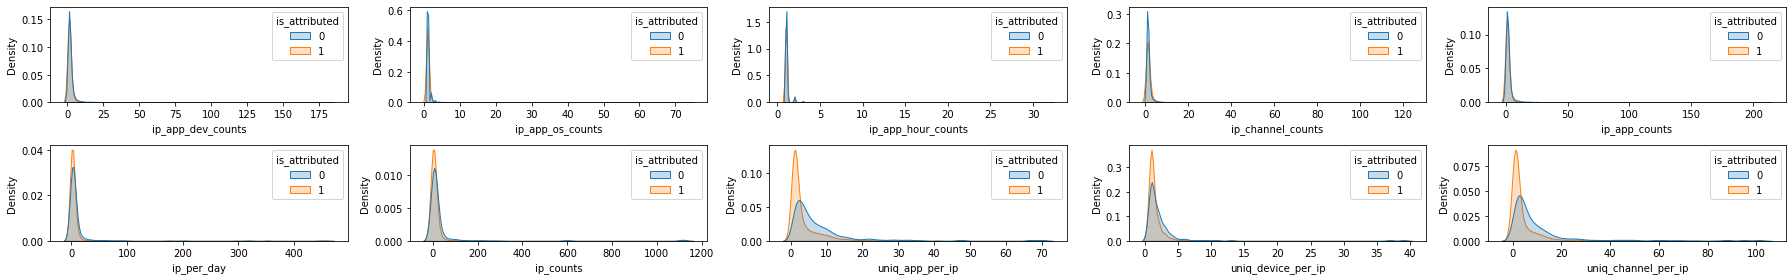

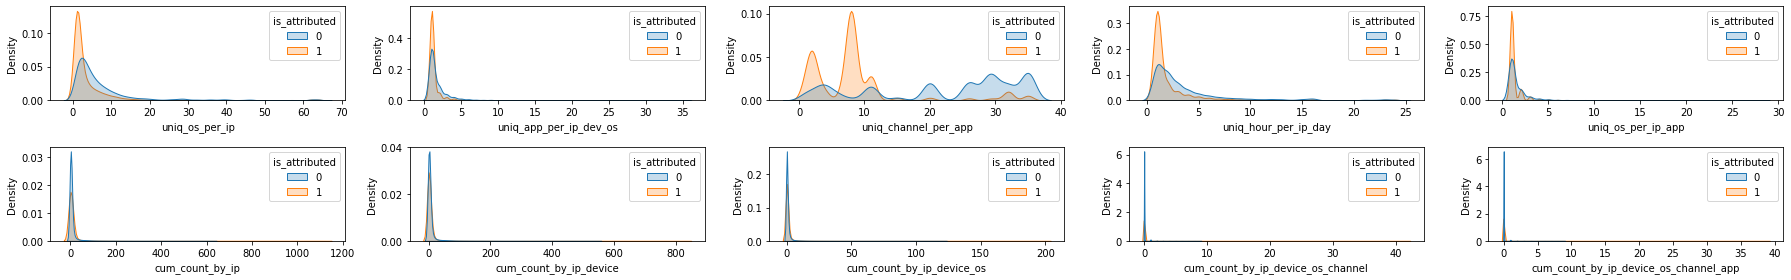

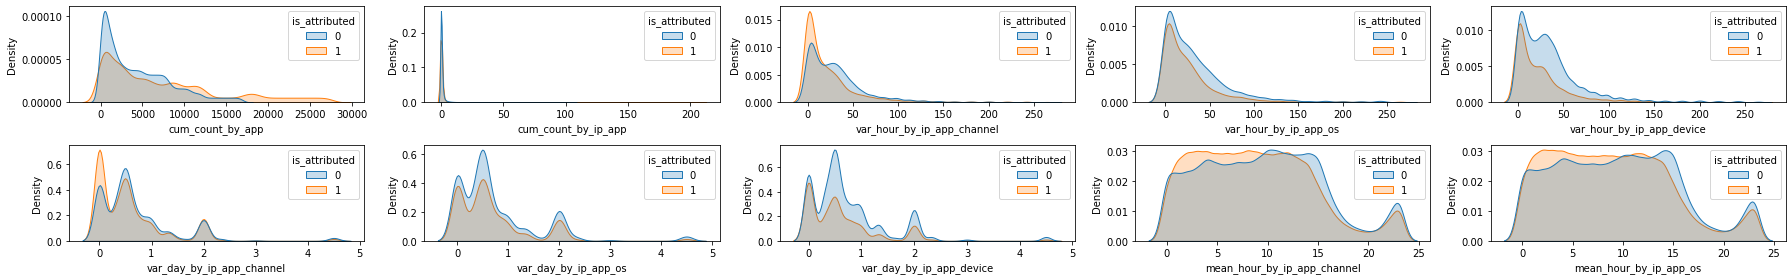

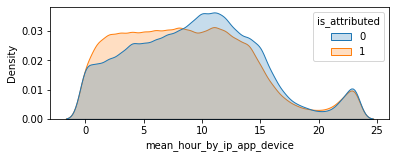

In [71]:
#plot all density plots -- 2 mins
r, c = 2, 5
total = r*c
print("Different combinations of aggregating original features: \n")
for i in range(0, len(xlab), total):
  x = xlab[i:i+total]
  plot_rbyc(train_agg, x, r, c)

## Time till next click

In [47]:
## Added from EDA
train_datetime = pd.to_datetime(train['click_time'], format='%Y-%m-%d %H:%M:%S')
train['click_time'] = train_datetime

GROUP_BY_NEXT_CLICKS = [
    
    # ip with one other feature
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'device']},
    {'groupby': ['ip', 'os']},
    {'groupby': ['ip', 'channel']},
    
    
    # ip with two other features
    {'groupby': ['ip', 'app', 'device']},
    {'groupby': ['ip', 'app', 'os']},
    {'groupby': ['ip', 'app', 'channel']},
    {'groupby': ['ip', 'device', 'os']},
    {'groupby': ['ip', 'device', 'channel']},
    {'groupby': ['ip', 'os', 'channel']},

    # ip with three other features
    {'groupby': ['ip', 'app', 'device', 'os']},
    {'groupby': ['ip', 'app', 'device', 'channel']},
    {'groupby': ['ip', 'device', 'os', 'channel']},

    # ip with all other features
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']}
]

# Calculate the time to next click for each group
for spec in GROUP_BY_NEXT_CLICKS:
    
    # Name of new feature
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    # Run calculation
    print(f">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    train[new_feature] = train[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    
train.head()

>> Grouping by ['ip'], and saving time to next click in: ip_nextClick
>> Grouping by ['ip', 'app'], and saving time to next click in: ip_app_nextClick
>> Grouping by ['ip', 'device'], and saving time to next click in: ip_device_nextClick
>> Grouping by ['ip', 'os'], and saving time to next click in: ip_os_nextClick
>> Grouping by ['ip', 'channel'], and saving time to next click in: ip_channel_nextClick
>> Grouping by ['ip', 'app', 'device'], and saving time to next click in: ip_app_device_nextClick
>> Grouping by ['ip', 'app', 'os'], and saving time to next click in: ip_app_os_nextClick
>> Grouping by ['ip', 'app', 'channel'], and saving time to next click in: ip_app_channel_nextClick
>> Grouping by ['ip', 'device', 'os'], and saving time to next click in: ip_device_os_nextClick
>> Grouping by ['ip', 'device', 'channel'], and saving time to next click in: ip_device_channel_nextClick
>> Grouping by ['ip', 'os', 'channel'], and saving time to next click in: ip_os_channel_nextClick
>> Gro

ip  app  device  os  channel          click_time  is_attributed  day  \
0  116992   15       1  34      245 2017-11-07 06:18:26              0    7   
1   92610    3       1  13      280 2017-11-07 03:06:29              0    7   
2   79894    2       1  19      122 2017-11-07 11:15:24              0    7   
3   32746    3       1  31      480 2017-11-08 14:44:58              0    8   
4    1638    2       1  20      236 2017-11-09 10:24:38              0    9   

   hour  minute  ...  ip_app_device_nextClick  ip_app_os_nextClick  \
0     6      18  ...                  31022.0                  NaN   
1     3       6  ...                  10969.0              10969.0   
2    11      15  ...                      NaN                  NaN   
3    14      44  ...                  42475.0                  NaN   
4    10      24  ...                   9224.0                  NaN   

   ip_app_channel_nextClick  ip_device_os_nextClick  \
0                   59605.0                     NaN   
1                       NaN                 10969.0   
2                       NaN                     NaN   
3                       NaN                     NaN   
4                       NaN                     NaN   

   ip_device_channel_nextClick  ip_os_channel_nextClick  \
0                      59605.0                      NaN   
1                          NaN                      NaN   
2                          NaN                      NaN   
3                          NaN                      NaN   
4                          NaN                      NaN   

   ip_app_device_os_nextClick  ip_app_device_channel_nextClick  \
0                         NaN                          59605.0   
1                     10969.0                              NaN   
2                         NaN                              NaN   
3                         NaN                              NaN   
4                         NaN                              NaN   

   ip_device_os_channel_nextClick  ip_app_device_os_channel_nextClick  
0                             NaN                                 NaN  
1                             NaN                                 NaN  
2                             NaN                                 NaN  
3                             NaN                                 NaN  
4                             NaN                                 NaN  

[5 rows x 26 columns]

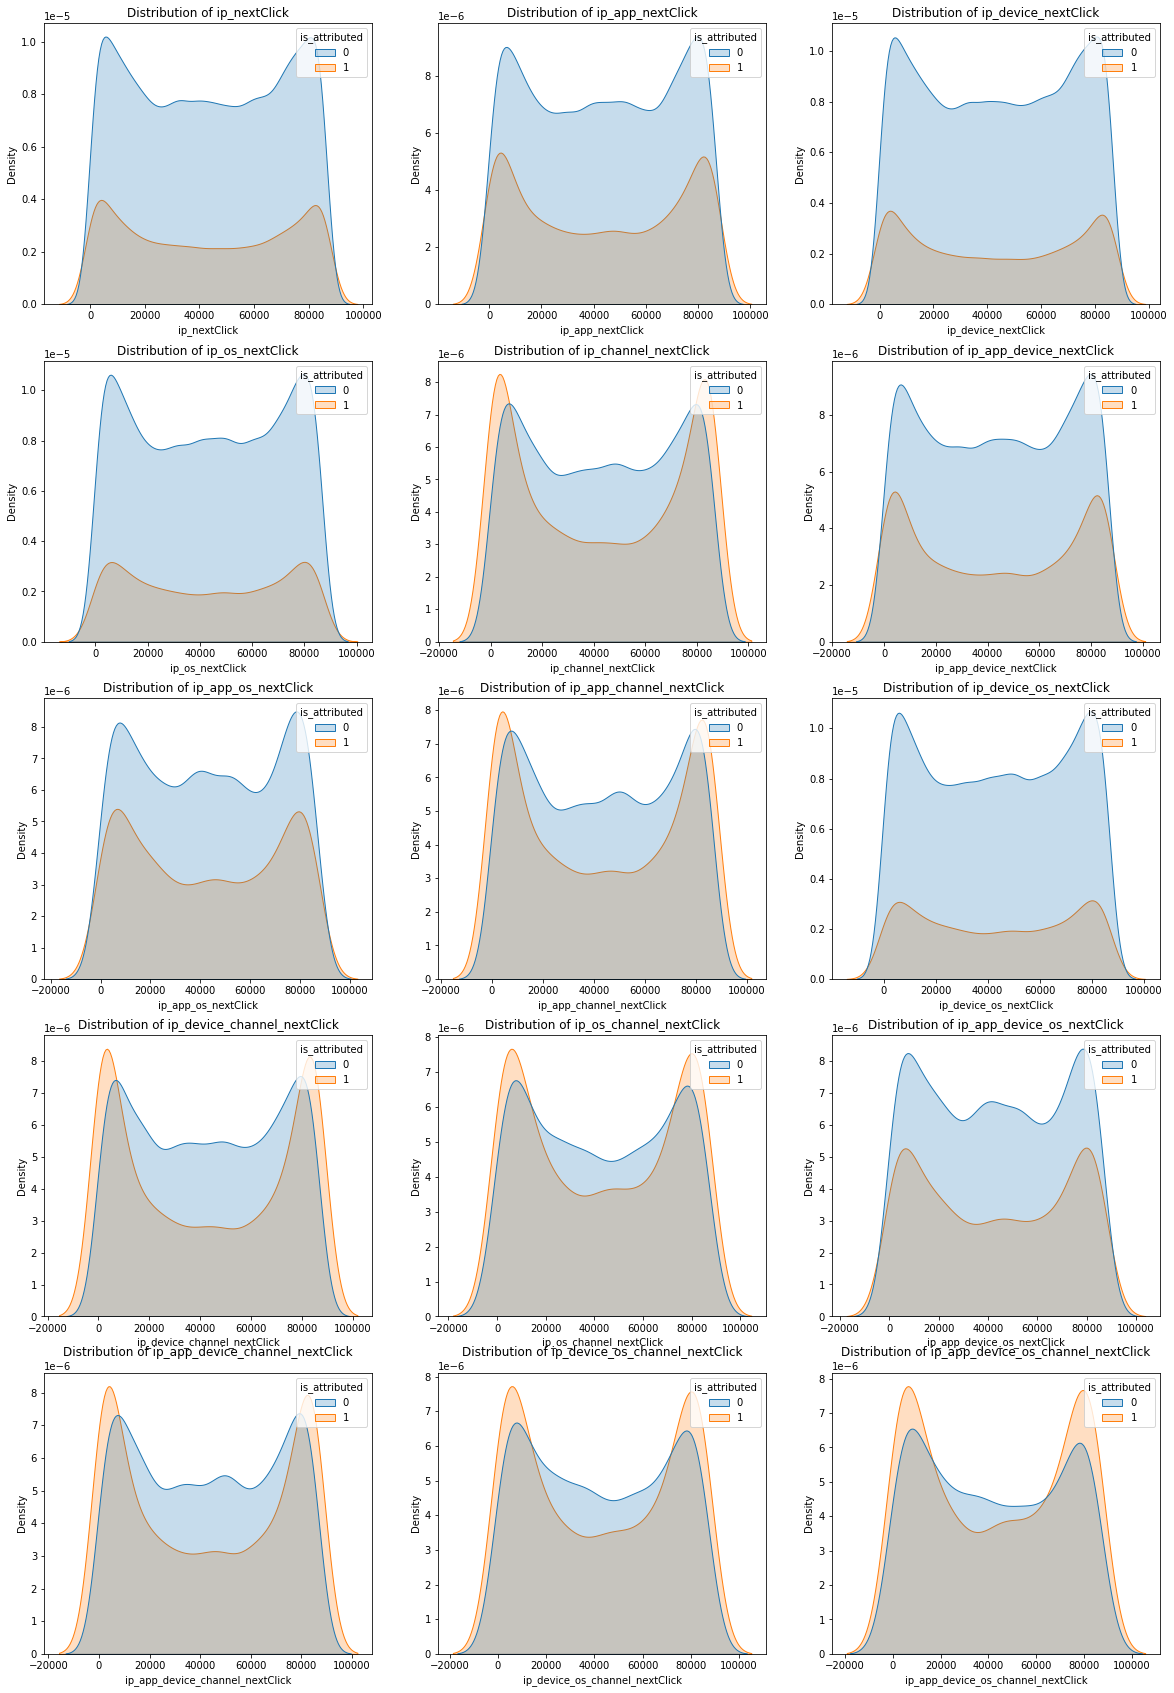

In [65]:
#density plots get array of labels

plt.figure(figsize=(20, 30))
for index, var in enumerate(train.columns[11:]):
  plt.subplot(5, 3, index+1)
  sns.kdeplot(data=train, x=var, hue="is_attributed", fill=True)
  plt.title(f"Distribution of {var}")

plt.show()

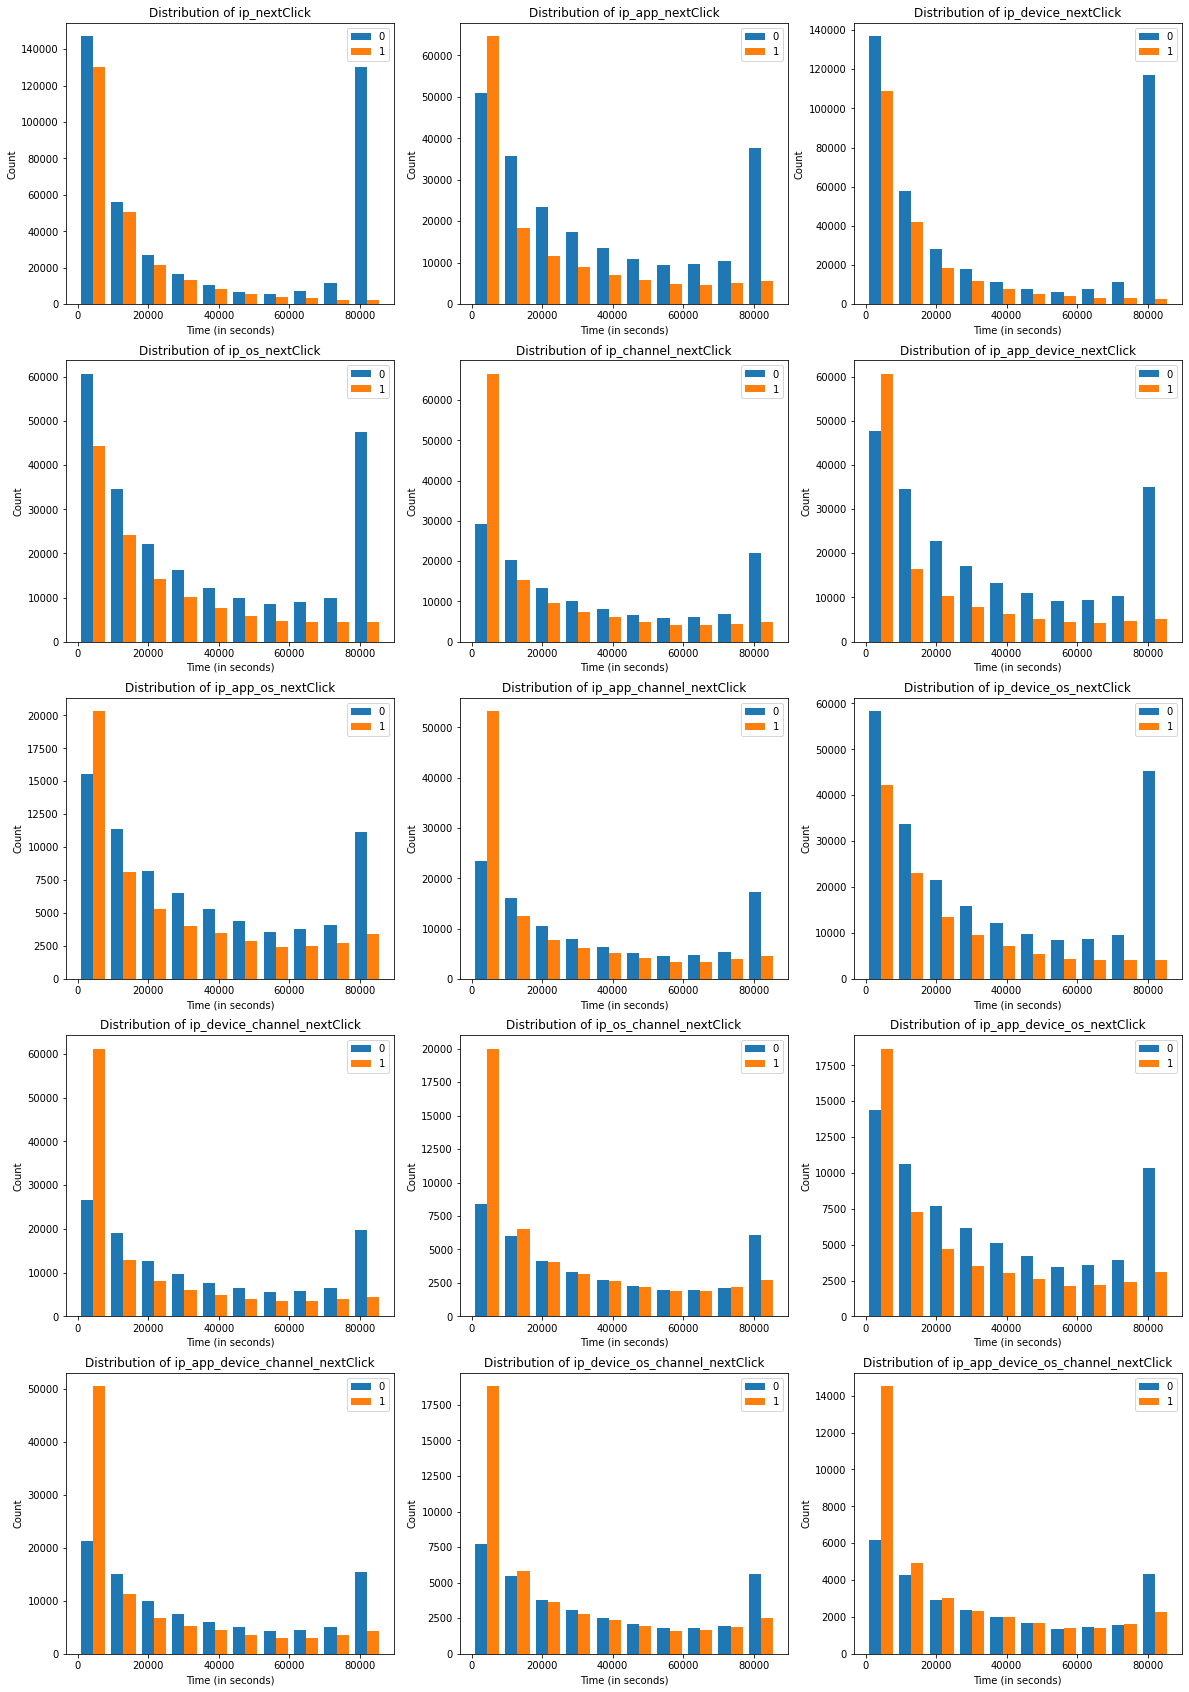

In [ ]:
# plt.figure(figsize=(20, 30))
# for index, var in enumerate(train.columns[11:26]):
#   plt.subplot(5, 3, index+1)
#   var_0 = train[train['is_attributed']==0][var]
#   var_1 = train[train['is_attributed']==1][var]
#   plt.hist([var_0, var_1], label=["0", "1"])
#   plt.legend(loc="best")
#   plt.ylabel('Count')
#   plt.xlabel('Time (in seconds)')
#   plt.title(f"Distribution of {var}")

# plt.show()

In [ ]:
## for normal entries, they peak when the time btw clicks is ard 0s
## on the other hand for fraud entries, they when the time btw clicks is ard 0s and 80000s (ard 1 day)

215131

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/BT4012/dataset/train_FE5.csv')

In [ ]:
plt.figure(figsize=(20, 30))
for index, var in enumerate(data.columns[11:26]):
  plt.subplot(5, 3, index+1)
  sns.kdeplot(data=data, x=var, hue="is_attributed", fill=True)
  plt.title(f"Distribution of {var}")

plt.show()

##  Clicks on app ad before & after

In [259]:
HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

# Go through different group-by combinations
for fname, fset in HISTORY_CLICKS.items():
    
    # Clicks in the past
    train['prev_'+fname] = train.groupby(fset).cumcount().rename('prev_'+fname)
        
    # Clicks in the future
    train['future_'+fname] = train.iloc[::-1].groupby(fset).cumcount().rename('future_'+fname).iloc[::-1]
 
train.head()

ip  app  device  os  channel          click_time  is_attributed  day  \
0  116992   15       1  34      245 2017-11-07 06:18:26              0    7   
1   92610    3       1  13      280 2017-11-07 03:06:29              0    7   
2   79894    2       1  19      122 2017-11-07 11:15:24              0    7   
3   32746    3       1  31      480 2017-11-08 14:44:58              0    8   
4    1638    2       1  20      236 2017-11-09 10:24:38              0    9   

   hour  minute  ...  ip_device_channel_nextClick ip_os_channel_nextClick  \
0     6      18  ...                      59605.0                     NaN   
1     3       6  ...                          NaN                     NaN   
2    11      15  ...                          NaN                     NaN   
3    14      44  ...                          NaN                     NaN   
4    10      24  ...                          NaN                     NaN   

  ip_app_device_os_nextClick  ip_app_device_channel_nextClick  \
0                        NaN                          59605.0   
1                    10969.0                              NaN   
2                        NaN                              NaN   
3                        NaN                              NaN   
4                        NaN                              NaN   

   ip_device_os_channel_nextClick  ip_app_device_os_channel_nextClick  \
0                             NaN                                 NaN   
1                             NaN                                 NaN   
2                             NaN                                 NaN   
3                             NaN                                 NaN   
4                             NaN                                 NaN   

   prev_identical_clicks  future_identical_clicks  prev_app_clicks  \
0                      0                        0                0   
1                      0                        0                0   
2                      0                        0                0   
3                      0                        0                0   
4                      0                        0                0   

   future_app_clicks  
0                  3  
1                  1  
2                  0  
3                  1  
4                  1  

[5 rows x 66 columns]

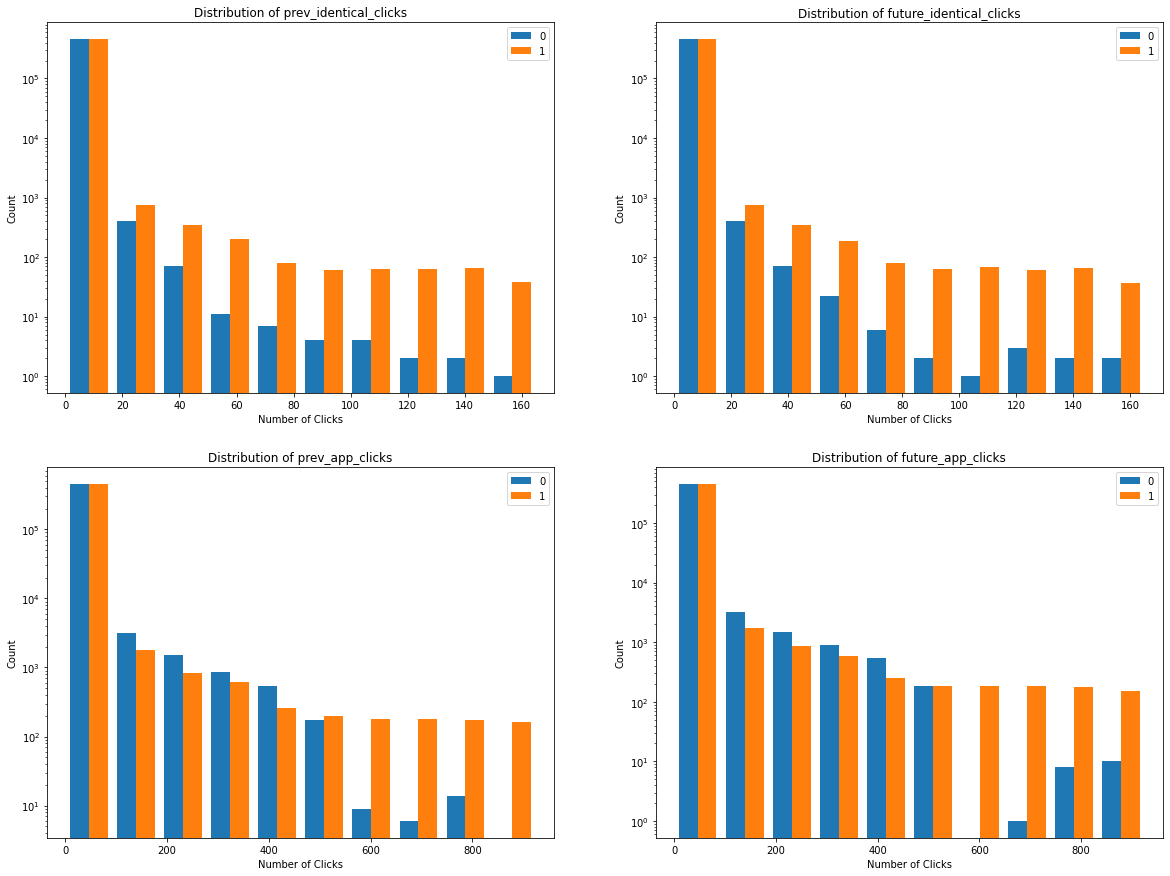

In [ ]:
# plt.figure(figsize=(20, 15))
# for index, var in enumerate(train.columns[26:30]):
#   plt.subplot(2, 2, index+1)
#   var_0 = train[train['is_attributed']==0][var]
#   var_1 = train[train['is_attributed']==1][var]
#   plt.hist([var_0, var_1], label=["0", "1"])
#   plt.legend(loc="best")
#   plt.yscale("log")
#   plt.ylabel('Count')
#   plt.xlabel('Number of Clicks')
#   plt.title(f"Distribution of {var}")

# plt.show()

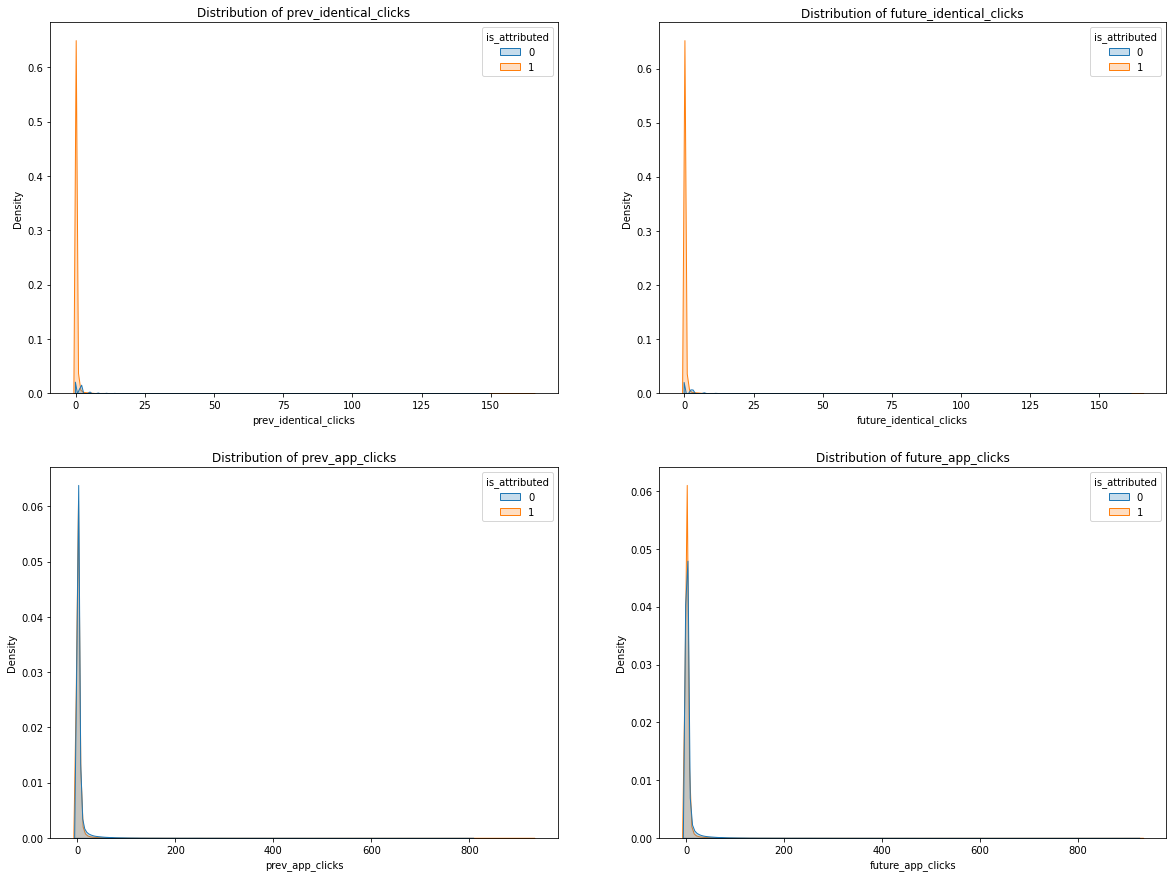

In [ ]:
plt.figure(figsize=(20, 15))
for index, var in enumerate(data.columns[26:30]):
  plt.subplot(2, 2, index+1)
  sns.kdeplot(data=data, x=var, hue="is_attributed", fill=True)
  plt.title(f"Distribution of {var}")

plt.show()

## Confidence Rates for is_attributed

In [260]:
ATTRIBUTION_CATEGORIES = [        
    # V1 Features #
    ['ip'], ['app'], ['device'], ['os'], ['channel'],
    
    # V2 Features #
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    
    # V3 Features #
    ['channel', 'os'],
    ['channel', 'device'],
    ['os', 'device']
]


# Find frequency of is_attributed for each unique value in column
freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = train.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(10**6) # 1000 views -> 50% confidence, 100 views -> 33% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}.".format(cols, new_feature))
    
    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    # Perform the merge
    train = train.merge(
        group_object['is_attributed'].apply(rate_calculation).reset_index().
        rename(index=str,columns={'is_attributed': new_feature})[cols + [new_feature]],
        on=cols, how='left'
    )
    
train.head()

>> Calculating confidence-weighted rate for: ['ip'].
   Saving to: ip_confRate.
>> Calculating confidence-weighted rate for: ['app'].
   Saving to: app_confRate.
>> Calculating confidence-weighted rate for: ['device'].
   Saving to: device_confRate.
>> Calculating confidence-weighted rate for: ['os'].
   Saving to: os_confRate.
>> Calculating confidence-weighted rate for: ['channel'].
   Saving to: channel_confRate.
>> Calculating confidence-weighted rate for: ['app', 'channel'].
   Saving to: app_channel_confRate.
>> Calculating confidence-weighted rate for: ['app', 'os'].
   Saving to: app_os_confRate.
>> Calculating confidence-weighted rate for: ['app', 'device'].
   Saving to: app_device_confRate.
>> Calculating confidence-weighted rate for: ['channel', 'os'].
   Saving to: channel_os_confRate.
>> Calculating confidence-weighted rate for: ['channel', 'device'].
   Saving to: channel_device_confRate.
>> Calculating confidence-weighted rate for: ['os', 'device'].
   Saving to: os_dev

ip  app  device  os  channel          click_time  is_attributed  day  \
0  116992   15       1  34      245 2017-11-07 06:18:26              0    7   
1   92610    3       1  13      280 2017-11-07 03:06:29              0    7   
2   79894    2       1  19      122 2017-11-07 11:15:24              0    7   
3   32746    3       1  31      480 2017-11-08 14:44:58              0    8   
4    1638    2       1  20      236 2017-11-09 10:24:38              0    9   

   hour  minute  ...  app_confRate device_confRate os_confRate  \
0     6      18  ...      0.051893        0.358049    0.155254   
1     3       6  ...      0.076292        0.358049    0.288087   
2    11      15  ...      0.065913        0.358049    0.322458   
3    14      44  ...      0.076292        0.358049    0.156693   
4    10      24  ...      0.065913        0.358049    0.199521   

   channel_confRate  app_channel_confRate  app_os_confRate  \
0          0.022429              0.025245         0.000000   
1          0.063045              0.053648         0.059310   
2          0.090301              0.059503         0.069368   
3          0.042289              0.039638         0.017383   
4          0.054623              0.054623         0.022488   

   app_device_confRate  channel_os_confRate  channel_device_confRate  \
0             0.053586             0.000000                 0.023461   
1             0.077493             0.051676                 0.064268   
2             0.068332             0.091254                 0.093129   
3             0.077493             0.000000                 0.042177   
4             0.068332             0.011217                 0.054977   

   os_device_confRate  
0            0.157936  
1            0.292719  
2            0.325176  
3            0.158367  
4            0.204446  

[5 rows x 77 columns]

In [ ]:
plt.figure(figsize=(20, 30))
for index, var in enumerate(train.columns[40:]):
  plt.subplot(6, 2, index+1)
  plt.scatter(x="ip", y=var, data=train[train['is_attributed']==1], color="orange", alpha=0.1)
  plt.scatter(x="ip", y=var, data=train[train['is_attributed']==0], color="blue", alpha=0.1)
  plt.legend(["1", "0"], loc="best")
  plt.ylabel('Confidence Rate')
  plt.xlabel('IP')
  plt.title(f"Distribution of {var}")

plt.show()

## Combining device & IP

In [263]:
train['device_ip'] = train['device'].map(str) + train['ip'].map(str)
train.head()

ip  app  device  os  channel          click_time  is_attributed  day  \
0  116992   15       1  34      245 2017-11-07 06:18:26              0    7   
1   92610    3       1  13      280 2017-11-07 03:06:29              0    7   
2   79894    2       1  19      122 2017-11-07 11:15:24              0    7   
3   32746    3       1  31      480 2017-11-08 14:44:58              0    8   
4    1638    2       1  20      236 2017-11-09 10:24:38              0    9   

   hour  minute  ...  device_confRate os_confRate channel_confRate  \
0     6      18  ...         0.358049    0.155254         0.022429   
1     3       6  ...         0.358049    0.288087         0.063045   
2    11      15  ...         0.358049    0.322458         0.090301   
3    14      44  ...         0.358049    0.156693         0.042289   
4    10      24  ...         0.358049    0.199521         0.054623   

   app_channel_confRate  app_os_confRate  app_device_confRate  \
0              0.025245         0.000000             0.053586   
1              0.053648         0.059310             0.077493   
2              0.059503         0.069368             0.068332   
3              0.039638         0.017383             0.077493   
4              0.054623         0.022488             0.068332   

   channel_os_confRate  channel_device_confRate  os_device_confRate  device_ip  
0             0.000000                 0.023461            0.157936    1116992  
1             0.051676                 0.064268            0.292719     192610  
2             0.091254                 0.093129            0.325176     179894  
3             0.000000                 0.042177            0.158367     132746  
4             0.011217                 0.054977            0.204446      11638  

[5 rows x 78 columns]

In [264]:
device_ip_1 = train[train['is_attributed'] == 1]['device_ip']
device_ip_0 = train[train['is_attributed'] == 0]['device_ip']

set_device_ip_1 = set(device_ip_1.unique())
set_device_ip_0 = set(device_ip_0.unique())

print('No. of unique device_ip that downloaded app:', len(set_device_ip_1))
print('No. of unique device_ip that did not download app:', len(set_device_ip_0))

No. of unique device_ip that downloaded app: 72740
No. of unique device_ip that did not download app: 35883


In [265]:
# device_ip that always download app after clicking
device_ip_download = set_device_ip_1.difference(set_device_ip_0)

# device_ip that always do not download app after clicking
device_ip_fraud = set_device_ip_0.difference(set_device_ip_1)

print('No. of device_ip that ALWAYS downloaded app:', len(device_ip_download))
print('No. of device_ip that NEVER downloaded app:', len(device_ip_fraud))

No. of device_ip that ALWAYS downloaded app: 59913
No. of device_ip that NEVER downloaded app: 23056


In [266]:
pct_device_ip_download = (len(device_ip_download) / len(set_device_ip_1))*100
pct_device_ip_fraud = (len(device_ip_fraud) / len(set_device_ip_0))*100

print('Percentage of device_ip that ALWAYS downloaded app:', round(pct_device_ip_download, 2), '%')
print('Percentage of device_ip that NEVER downloaded app:', round(pct_device_ip_fraud, 2), '%')

Percentage of device_ip that ALWAYS downloaded app: 82.37 %
Percentage of device_ip that NEVER downloaded app: 64.25 %


## Combining device & hour

In [267]:
train_hour_0 = train[train["is_attributed"] == 0]['hour']
train_hour_1 = train[train["is_attributed"] == 1]['hour']

In [268]:
train['device_hour'] = train['device'].map(str) + train['hour'].map(str)
train.head()

ip  app  device  os  channel          click_time  is_attributed  day  \
0  116992   15       1  34      245 2017-11-07 06:18:26              0    7   
1   92610    3       1  13      280 2017-11-07 03:06:29              0    7   
2   79894    2       1  19      122 2017-11-07 11:15:24              0    7   
3   32746    3       1  31      480 2017-11-08 14:44:58              0    8   
4    1638    2       1  20      236 2017-11-09 10:24:38              0    9   

   hour  minute  ...  os_confRate channel_confRate app_channel_confRate  \
0     6      18  ...     0.155254         0.022429             0.025245   
1     3       6  ...     0.288087         0.063045             0.053648   
2    11      15  ...     0.322458         0.090301             0.059503   
3    14      44  ...     0.156693         0.042289             0.039638   
4    10      24  ...     0.199521         0.054623             0.054623   

   app_os_confRate  app_device_confRate  channel_os_confRate  \
0         0.000000             0.053586             0.000000   
1         0.059310             0.077493             0.051676   
2         0.069368             0.068332             0.091254   
3         0.017383             0.077493             0.000000   
4         0.022488             0.068332             0.011217   

   channel_device_confRate  os_device_confRate  device_ip  device_hour  
0                 0.023461            0.157936    1116992           16  
1                 0.064268            0.292719     192610           13  
2                 0.093129            0.325176     179894          111  
3                 0.042177            0.158367     132746          114  
4                 0.054977            0.204446      11638          110  

[5 rows x 79 columns]

In [269]:
device_hour_1 = train[train['is_attributed'] == 1]['device_hour']
device_hour_0 = train[train['is_attributed'] == 0]['device_hour']

set_device_hour_1 = set(device_hour_1.unique())
set_device_hour_0 = set(device_hour_0.unique())

print('No. of unique device_hour that downloaded app:', len(set_device_hour_1))
print('No. of unique device_hour that did not download app:', len(set_device_hour_0))

No. of unique device_hour that downloaded app: 3834
No. of unique device_hour that did not download app: 259


In [270]:
# device_hour that always download app after clicking
device_hour_download = set_device_hour_1.difference(set_device_hour_0)

# device_hour that always do not download app after clicking
device_hour_fraud = set_device_hour_0.difference(set_device_hour_1)

print('No. of device_hour that ALWAYS downloaded app:', len(device_hour_download))
print('No. of device_hour that NEVER downloaded app:', len(device_hour_fraud))

No. of device_hour that ALWAYS downloaded app: 3684
No. of device_hour that NEVER downloaded app: 109


In [271]:
pct_device_hour_download = (len(device_hour_download) / len(set_device_hour_1))*100
pct_device_hour_fraud = (len(device_hour_fraud) / len(set_device_hour_0))*100

print('Percentage of device_hour that ALWAYS downloaded app:', round(pct_device_hour_download, 2), '%')
print('Percentage of device_hour that NEVER downloaded app:', round(pct_device_hour_fraud, 2), '%')

Percentage of device_hour that ALWAYS downloaded app: 96.09 %
Percentage of device_hour that NEVER downloaded app: 42.08 %


### Channel, device, and dateTime conversion rate

In [272]:
train = pd.merge(train,conversion_rate_channel[['channel','conversion_rate']],on='channel')
train.rename({'conversion_rate': 'channel_conversion_rate'}, axis=1, inplace=True)
train = pd.merge(train,conversion_rate_device[['device','conversion_rate']],on='device')
train.rename({'conversion_rate': 'device_conversion_rate'}, axis=1, inplace=True)
conversion_rate_time = conversion_rate_time.reset_index(level=0)
train = pd.merge(train,conversion_rate_time[['dateTime','conversion_rate']],on='dateTime')
train.rename({'conversion_rate': 'dateTime_conversion_rate'}, axis=1, inplace=True)

In [273]:
##save the generated features
train.to_csv('./train_FE5.csv', index=False)

## Response Coding for Categorical Variables

In [70]:
from tqdm import tqdm

# what is alpha
def get_feature_dict(alpha, feature, df):
  value_count = train[feature].value_counts()
  feature_dict = dict()
  value_count_items = value_count.items()

  class_0 = train['is_attributed'] == 0
  class_1 = train['is_attributed'] == 1

  for i, denominator in tqdm(value_count_items):
    b = train[feature] == i
    vec = []

    for k in range(2):
      if k == 0:
        cls_cnt = train.loc[class_0 & b]
      else:
        cls_cnt = train.loc[class_1 & b]
      
      vec.append((cls_cnt.shape[0] + 10*alpha)/ (denominator + 20*alpha))
    
    feature_dict[i] = vec
  
  return feature_dict



def get_feature(alpha, feature, df, feature_dict):
  value_count = train[feature].value_counts()
  value_count_keys = dict(value_count).keys()
  
  feature = []
  for index, row in tqdm(df.iterrows()):
    if row[feature] in value_count_keys:
      feature.append(feature_dict[row[feature]])
    
    else:
      feature.append([1/2, 1/2])
  
  return feature

# Data Processing after new features generated

<p>Drop click_date and dateTime since they are redundant information</p>

In [34]:
data = data.drop(['click_date', 'dateTime'], axis = 1)

Deal with NaN values

In [35]:
checkna = [data[var].isnull().sum() for var in data.columns]
na_df = pd.DataFrame({"Variable": data.columns, "Number of Missing Values": checkna})

In [36]:
na_df[na_df["Number of Missing Values"] > 0]

Variable  Number of Missing Values
36          var_hour_by_ip_app_channel                    157117
37               var_hour_by_ip_app_os                    169616
38           var_hour_by_ip_app_device                    136110
39           var_day_by_ip_app_channel                    157117
40                var_day_by_ip_app_os                    169616
41            var_day_by_ip_app_device                    136110
45                        ip_nextClick                     84781
46                    ip_app_nextClick                    150549
47                 ip_device_nextClick                     95806
48                     ip_os_nextClick                    147780
49                ip_channel_nextClick                    162031
50             ip_app_device_nextClick                    153508
51                 ip_app_os_nextClick                    176142
52            ip_app_channel_nextClick                    167720
53              ip_device_os_nextClick                    149712
54         ip_device_channel_nextClick                    164979
55             ip_os_channel_nextClick                    179929
56          ip_app_device_os_nextClick                    177185
57     ip_app_device_channel_nextClick                    169561
58      ip_device_os_channel_nextClick                    180579
59  ip_app_device_os_channel_nextClick                    181906

Variables with the naming convention "var_variable_by_variablegroup" represent the variance of $variable$ among $variablegroup$. It has NaN values when there is only one value in $variablegroup$. To deal with such missing values, we can set the NaN values to be 0, meaning that there is no variance for $variable$ among $variablegroup$.

Variables with the naming convention "variablegroup_nextClick" represent the time till next click between items in $variablegroup$. It has NaN values when there is no click after the current one in the $variablegroup$. We can interpret such variables as has_nextClick * time_till_nextClick, where has_nextClick takes 0 when there is no next click and 1 otherwise. Therefore, we can then set the NaN values to be 0.

In [37]:
data.fillna(0, inplace=True)

In [38]:
checkna1 = [data[var].isnull().sum() for var in data.columns]
na_df1 = pd.DataFrame({"Variable": data.columns, "Number of Missing Values": checkna1})
len(na_df1[na_df1["Number of Missing Values"] > 0])

0

In [38]:
data = pd.read_csv("./train_FE_processed.csv")

In [40]:
data = data.drop(labels = ['channel_conversion_rate', 'device_conversion_rate',
       'dateTime_conversion_rate'], axis = 1)

In [42]:
data = data.drop(labels = ['ip_confRate', 'app_confRate', 'device_confRate', 'os_confRate',
       'channel_confRate', 'app_channel_confRate', 'app_os_confRate',
       'app_device_confRate', 'channel_os_confRate', 'channel_device_confRate',
       'os_device_confRate'], axis = 1)

In [50]:
##save the data after processing
data.to_csv('./train_FE_processed.csv', index=False)

# Categorical Encoding

In [2]:
import pandas as pd
#Import data
train = pd.read_csv("./train_FE_processed.csv")
train.head(3)

ip  app  device  os  channel  is_attributed  day  hour  minute  second  \
0  116992   15       1  34      245              0    7     6      18      26   
1  136145   12       1  22      245              0    7     6      10      42   
2   32371   15       1  11      245              0    7     6      51      41   

   ...  ip_app_device_os_nextClick  ip_app_device_channel_nextClick  \
0  ...                           0                            59605   
1  ...                           0                                0   
2  ...                           0                                0   

   ip_device_os_channel_nextClick  ip_app_device_os_channel_nextClick  \
0                               0                                   0   
1                               0                                   0   
2                               0                                   0   

   prev_identical_clicks  future_identical_clicks  prev_app_clicks  \
0                      0                        0                0   
1                      0                        0                0   
2                      0                        0                0   

   future_app_clicks  device_ip  device_hour  
0                  3    1116992           16  
1                  0    1136145           16  
2                  0     132371           16  

[3 rows x 65 columns]

The categorical features to be encoded includes **'ip', 'app', 'device', 'os', 'channel', 'device_ip', and 'device_hour'**. 

Since the number of unique categories is large for each of those categorical features, one-hot encoding is no longer suitable as using it will result in huge the feature space. 

We will be using **count encoding**, where each category in each categorical variable will be replaced by the count of that category. Currently, if the test set has a unknown never seen before categories, it is currently replaced by 0 so as not to throw error when transforming test set (need to research more how to better handle never seen before categories). 

In [3]:
import category_encoders as ce
categorical_features = ['ip', 'app', 'device', 'os', 'channel', 'device_ip', 'device_hour']
#normalize the counts here as the count seems too big which may affect gradient descent?
count_enc = ce.CountEncoder(cols=categorical_features, handle_unknown='value', normalize=True)
new_train_categories = count_enc.fit_transform(train[categorical_features])
new_train_categories.head()

ip       app    device        os   channel  device_ip  device_hour
0  0.000054  0.046462  0.805866  0.001024  0.024338   0.000054     0.046859
1  0.000005  0.068113  0.805866  0.034421  0.024338   0.000005     0.046859
2  0.000016  0.046462  0.805866  0.010651  0.024338   0.000016     0.046859
3  0.000005  0.046462  0.805866  0.010651  0.024338   0.000005     0.046859
4  0.000016  0.046462  0.805866  0.006420  0.024338   0.000005     0.046859

In [4]:
#replace original columns with data
train[categorical_features] = new_train_categories
train.head()

ip       app    device        os   channel  is_attributed  day  hour  \
0  0.000054  0.046462  0.805866  0.001024  0.024338              0    7     6   
1  0.000005  0.068113  0.805866  0.034421  0.024338              0    7     6   
2  0.000016  0.046462  0.805866  0.010651  0.024338              0    7     6   
3  0.000005  0.046462  0.805866  0.010651  0.024338              0    7     6   
4  0.000016  0.046462  0.805866  0.006420  0.024338              0    7     6   

   minute  second  ...  ip_app_device_os_nextClick  \
0      18      26  ...                           0   
1      10      42  ...                           0   
2      51      41  ...                           0   
3      34      39  ...                           0   
4      33      56  ...                           0   

   ip_app_device_channel_nextClick  ip_device_os_channel_nextClick  \
0                            59605                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   ip_app_device_os_channel_nextClick  prev_identical_clicks  \
0                                   0                      0   
1                                   0                      0   
2                                   0                      0   
3                                   0                      0   
4                                   0                      0   

   future_identical_clicks  prev_app_clicks  future_app_clicks  device_ip  \
0                        0                0                  3   0.000054   
1                        0                0                  0   0.000005   
2                        0                0                  0   0.000016   
3                        0                0                  0   0.000005   
4                        0                0                  0   0.000005   

   device_hour  
0     0.046859  
1     0.046859  
2     0.046859  
3     0.046859  
4     0.046859  

[5 rows x 65 columns]

In [16]:
#test set
#new_test_cat = count_enc.transform(test[categorical_features])

is_attributed        0        1
ip                             
0.000005       11157.0  48129.0
0.000011       11631.0   9401.0
0.000016        9507.0   5643.0
0.000021        7705.0   3843.0
0.000027        5827.0   2883.0
0.000032        4621.0   2207.0
0.000038        3409.0   1722.0
0.000043        2868.0      NaN
0.000048        2752.0      NaN
0.000054        2465.0      NaN
0.000059        2272.0      NaN
0.000064        2111.0      NaN
0.000070        2038.0      NaN


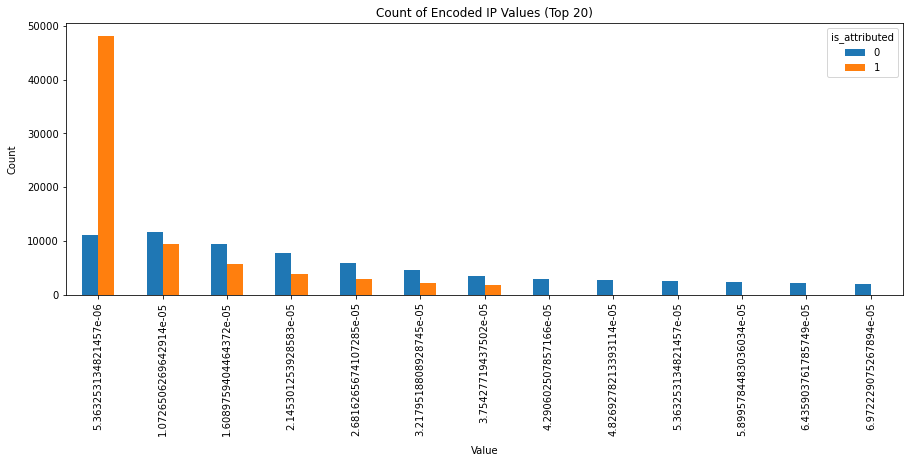

In [11]:
ip_encoded_value_counts = train.groupby(['ip']).is_attributed.value_counts().nlargest(20, keep='all').unstack()
print(ip_encoded_value_counts)

ip_encoded_value_counts.plot(kind='bar', figsize=(15, 5))
plt.xlabel("Value", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Count of Encoded IP Values (Top 20)");

is_attributed        0        1
app                            
0.010550        1878.0      NaN
0.012512           NaN   2324.0
0.013097        2287.0      NaN
0.016846        1813.0      NaN
0.017189        2966.0      NaN
0.018240           NaN   3371.0
0.030034        5086.0      NaN
0.031477           NaN   5705.0
0.039093           NaN   6942.0
0.046462        7978.0      NaN
0.047052           NaN   8468.0
0.052136        8023.0      NaN
0.063839       10748.0      NaN
0.065609        8459.0   3774.0
0.068113       12174.0      NaN
0.068542           NaN  12768.0
0.101864       16961.0   2032.0
0.148573           NaN  27290.0


Text(0.5, 1.0, 'Count of Encoded App Values (Top 20)')

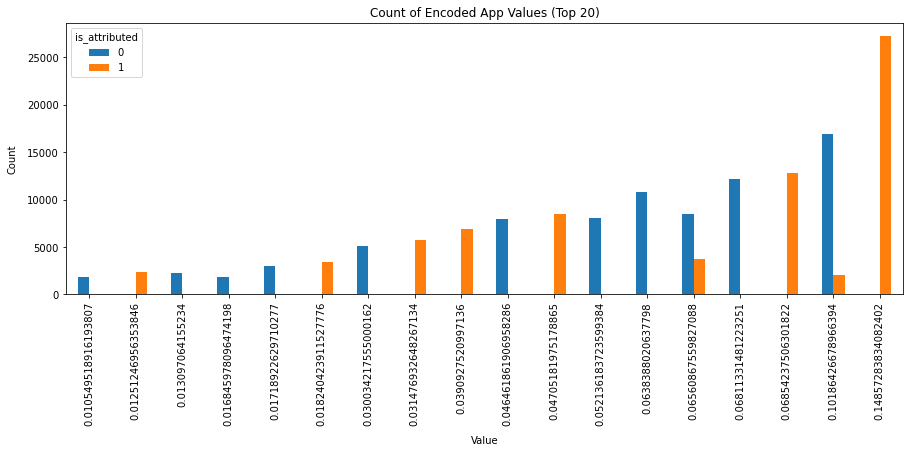

In [8]:
app_encoded_value_counts = train.groupby(['app']).is_attributed.value_counts().nlargest(20, keep='all').unstack()
print(app_encoded_value_counts)

app_encoded_value_counts.plot(kind='bar', figsize=(15, 5))
plt.xlabel("Value", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Count of Encoded App Values (Top 20)")

is_attributed        0        1
device                         
0.000005           NaN    425.0
0.000011           NaN    221.0
0.000016           NaN    233.0
0.000021           NaN    199.0
0.000032           NaN    218.0
0.000038           NaN    173.0
0.000359           NaN    200.0
0.001217           NaN    223.0
0.001427           NaN    264.0
0.001727           NaN    320.0
0.001807         336.0      NaN
0.002408           NaN    447.0
0.003084           NaN    568.0
0.003529           NaN    654.0
0.024660        4160.0    438.0
0.114398         467.0  20863.0
0.805866       87903.0  62354.0


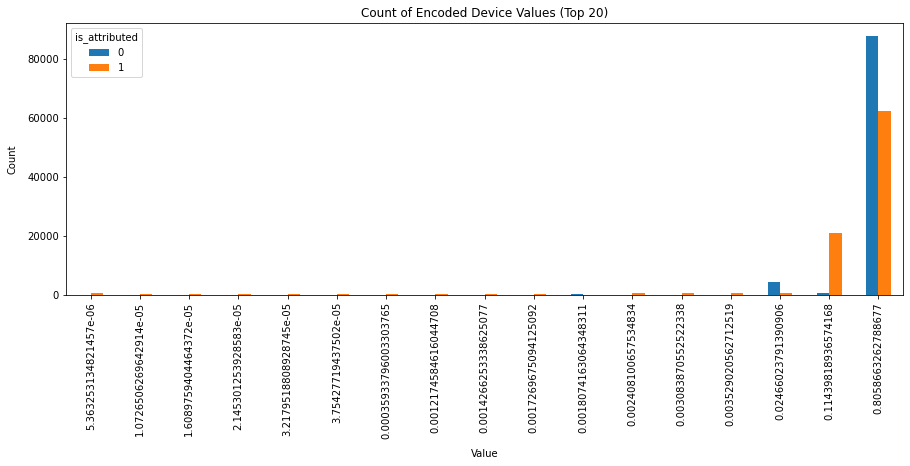

In [7]:
device_encoded_value_counts = train.groupby(['device']).is_attributed.value_counts().nlargest(20, keep='all').unstack()
print(device_encoded_value_counts)

device_encoded_value_counts.plot(kind='bar', figsize=(15, 5))
plt.xlabel("Value", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Count of Encoded Device Values (Top 20)")

is_attributed        0        1
os                             
0.013660           NaN   2467.0
0.015543        2267.0      NaN
0.016208        2163.0      NaN
0.018192        2281.0      NaN
0.020777        2730.0      NaN
0.021045           NaN   3885.0
0.021217        2645.0      NaN
0.022161           NaN   4084.0
0.034421        3823.0   2595.0
0.037023        4548.0   2355.0
0.039200        4974.0   2335.0
0.042606           NaN   7781.0
0.053627           NaN   9835.0
0.173936       20004.0  12427.0
0.206887       22302.0  16273.0


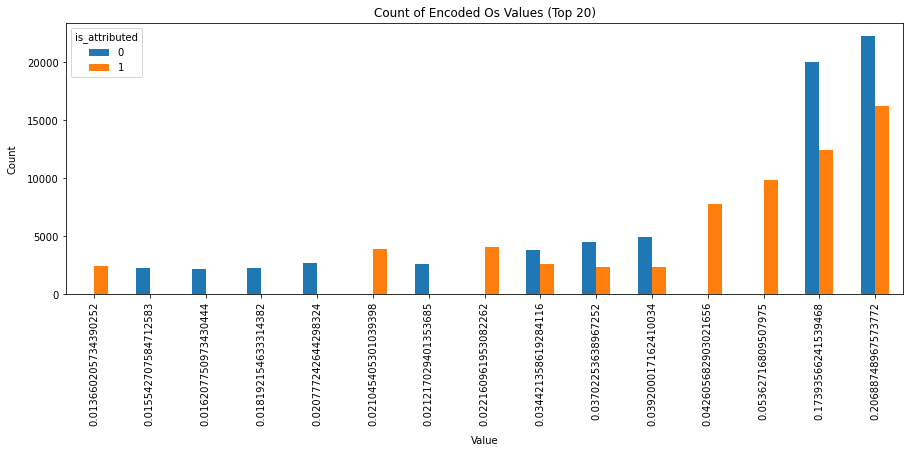

In [10]:
os_encoded_value_counts = train.groupby(['os']).is_attributed.value_counts().nlargest(20, keep='all').unstack()
print(os_encoded_value_counts)

os_encoded_value_counts.plot(kind='bar', figsize=(15, 5))
plt.xlabel("Value", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Count of Encoded Os Values (Top 20)");

is_attributed       0        1
channel                       
0.007825       2331.0      NaN
0.010491          NaN   1934.0
0.012512       2441.0   2225.0
0.014615       2615.0      NaN
0.015242       2690.0      NaN
0.015328       2441.0      NaN
0.015580       2779.0      NaN
0.018139       2852.0      NaN
0.020166       3038.0      NaN
0.021019       3663.0      NaN
0.022837          NaN   3801.0
0.024338       4371.0      NaN
0.027288          NaN   5085.0
0.028012       4320.0      NaN
0.042305          NaN   6712.0
0.043759       7370.0      NaN
0.046263          NaN   8511.0
0.062696          NaN  11441.0
0.150530          NaN  27724.0


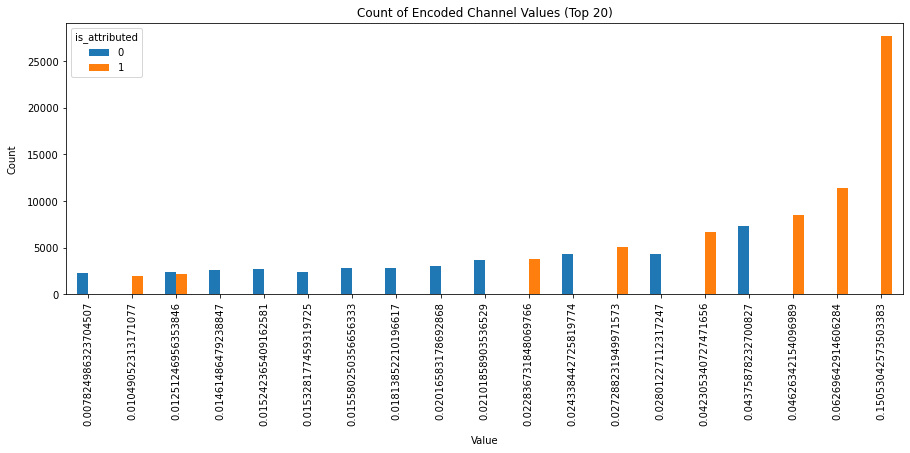

In [12]:
channel_encoded_value_counts = train.groupby(['channel']).is_attributed.value_counts().nlargest(20, keep='all').unstack()
print(channel_encoded_value_counts)

channel_encoded_value_counts.plot(kind='bar', figsize=(15, 5))
plt.xlabel("Value", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Count of Encoded Channel Values (Top 20)");

is_attributed        0        1
device_ip                      
0.000005       14637.0  55107.0
0.000011       12375.0   9201.0
0.000016        9788.0   4990.0
0.000021        7815.0   3253.0
0.000027        5809.0   2516.0
0.000032        4488.0   1860.0
0.000038        3570.0   1491.0
0.000043        3061.0      NaN
0.000048        2812.0      NaN
0.000054        2556.0      NaN
0.000059        2078.0      NaN
0.000064        1981.0      NaN
0.000070        1801.0      NaN


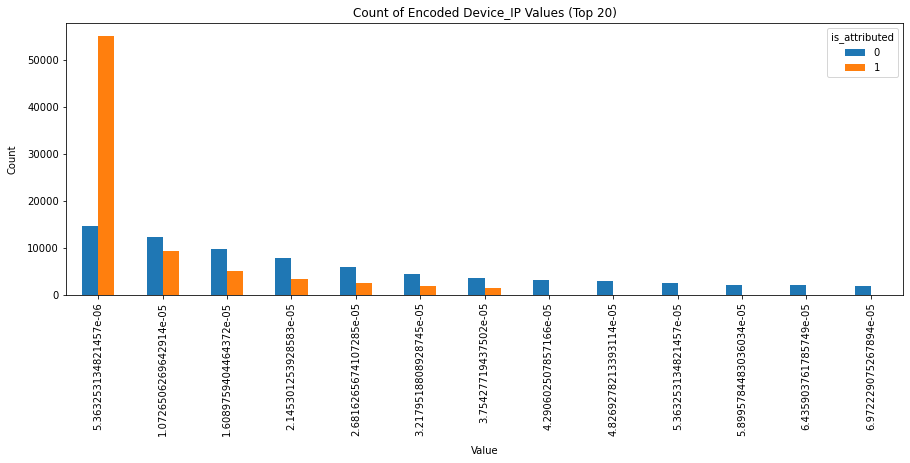

In [13]:
device_ip_encoded_value_counts = train.groupby(['device_ip']).is_attributed.value_counts().nlargest(20, keep='all').unstack()
print(device_ip_encoded_value_counts)

device_ip_encoded_value_counts.plot(kind='bar', figsize=(15, 5))
plt.xlabel("Value", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Count of Encoded Device_IP Values (Top 20)");

is_attributed       0       1
device_hour                  
0.040257       4637.0     NaN
0.040310       4350.0     NaN
0.040503       4387.0     NaN
0.040653       4592.0     NaN
0.041029       5581.0     NaN
0.044703       4474.0     NaN
0.044853       5420.0     NaN
0.046859       4529.0     NaN
0.051535       4812.0  4797.0
0.051825       5070.0  4593.0
0.054920       4496.0  5744.0
0.056421       4604.0  5916.0
0.056464       4608.0  5920.0
0.058229       5309.0  5548.0


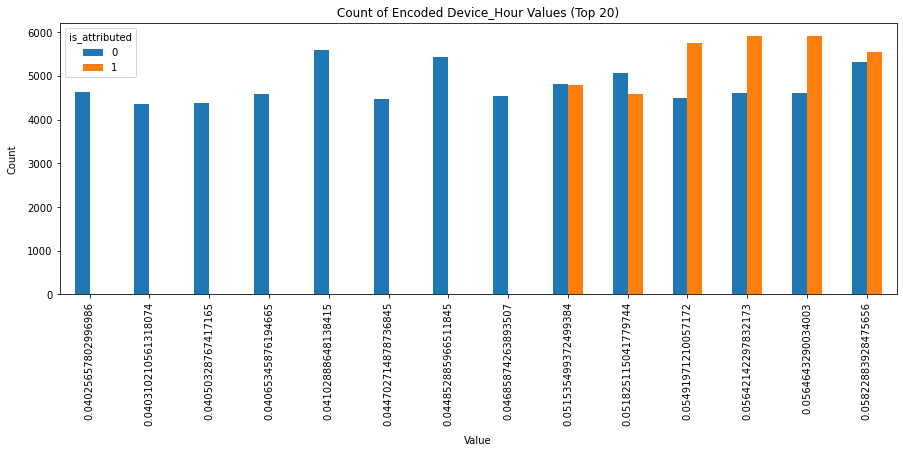

In [15]:
device_hour_encoded_value_counts = train.groupby(['device_hour']).is_attributed.value_counts().nlargest(20, keep='all').unstack()
print(device_hour_encoded_value_counts)

device_hour_encoded_value_counts.plot(kind='bar', figsize=(15, 5))
plt.xlabel("Value", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Count of Encoded Device_Hour Values (Top 20)");

# Feature Selection

In [23]:
train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'day', 'hour',
       'minute', 'second', 'dayOfWeek', 'ip_app_dev_os_cha_counts',
       'ip_app_dev_os_counts', 'ip_app_dev_counts', 'ip_app_os_counts',
       'ip_app_hour_counts', 'ip_channel_counts', 'ip_app_counts',
       'ip_per_day', 'ip_counts', 'uniq_app_per_ip', 'uniq_device_per_ip',
       'uniq_channel_per_ip', 'uniq_os_per_ip', 'uniq_app_per_ip_dev_os',
       'uniq_channel_per_app', 'uniq_hour_per_ip_day', 'uniq_os_per_ip_app',
       'cum_count_by_ip', 'cum_count_by_ip_device',
       'cum_count_by_ip_device_os', 'cum_count_by_ip_device_os_channel',
       'cum_count_by_ip_device_os_channel_app', 'cum_count_by_app',
       'cum_count_by_ip_app', 'var_hour_by_ip_app_channel',
       'var_hour_by_ip_app_os', 'var_hour_by_ip_app_device',
       'var_day_by_ip_app_channel', 'var_day_by_ip_app_os',
       'var_day_by_ip_app_device', 'mean_hour_by_ip_app_channel',
       'mean_hour_by_ip_app_os', 'mean_hour_by_i

In [25]:
X_train = train.drop(labels = 'is_attributed', axis = 1)
Y_train = train["is_attributed"]

In [25]:
X_train.dtypes

ip                         float64
app                        float64
device                     float64
os                         float64
channel                    float64
                            ...   
future_identical_clicks      int64
prev_app_clicks              int64
future_app_clicks            int64
device_ip                  float64
device_hour                float64
Length: 64, dtype: object

## Correlation between features

In [26]:
c = X_train.corr().abs()

s = c.unstack()
so = s.sort_values(ascending = False)
so = so.reset_index()
so.rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'correlation'}, inplace=True)

In [27]:
#remove correlation between the same features
filtered_so = so[so['feature_1'] != so['feature_2']]
filtered_so[filtered_so["correlation"] >= 0.9]

feature_1  \
0                                       ip   
1                                ip_counts   
2                                      day   
3                                dayOfWeek   
34   cum_count_by_ip_device_os_channel_app   
44                   prev_identical_clicks   
45                     cum_count_by_ip_app   
48                         prev_app_clicks   
72                          uniq_os_per_ip   
73                     uniq_channel_per_ip   
74                     uniq_channel_per_ip   
75                         uniq_app_per_ip   
76                                    hour   
77                  mean_hour_by_ip_app_os   
78                          uniq_os_per_ip   
79                         uniq_app_per_ip   
80                              ip_per_day   
81                                      ip   
82                              ip_per_day   
83                               ip_counts   
84   cum_count_by_ip_device_os_channel_app   
85                   prev_identical_clicks   
86       cum_count_by_ip_device_os_channel   
87       cum_count_by_ip_device_os_channel   
88                               ip_counts   
89                      uniq_device_per_ip   
90                      uniq_device_per_ip   
91                                      ip   
92             mean_hour_by_ip_app_channel   
93                  mean_hour_by_ip_app_os   
94                                    hour   
95             mean_hour_by_ip_app_channel   
96                         ip_os_nextClick   
97                  ip_device_os_nextClick   
98              mean_hour_by_ip_app_device   
99             mean_hour_by_ip_app_channel   
100                             ip_per_day   
101                     uniq_device_per_ip   
102                   ip_app_dev_os_counts   
103                       ip_app_os_counts   
104                ip_os_channel_nextClick   
105         ip_device_os_channel_nextClick   
106                      ip_app_dev_counts   
107                          ip_app_counts   
108                 mean_hour_by_ip_app_os   
109             mean_hour_by_ip_app_device   
110                ip_app_device_nextClick   
111                       ip_app_nextClick   
112             ip_app_device_os_nextClick   
113                    ip_app_os_nextClick   
114        ip_app_device_channel_nextClick   
115               ip_app_channel_nextClick   
116                   uniq_hour_per_ip_day   
117                         uniq_os_per_ip   
118                                   hour   
119             mean_hour_by_ip_app_device   
120                    uniq_channel_per_ip   
121                   uniq_hour_per_ip_day   
122                   ip_channel_nextClick   
123            ip_device_channel_nextClick   

                                 feature_2  correlation  
0                                ip_counts     1.000000  
1                                       ip     1.000000  
2                                dayOfWeek     1.000000  
3                                      day     1.000000  
34                   prev_identical_clicks     1.000000  
44   cum_count_by_ip_device_os_channel_app     1.000000  
45                         prev_app_clicks     1.000000  
48                     cum_count_by_ip_app     1.000000  
72                     uniq_channel_per_ip     0.983604  
73                          uniq_os_per_ip     0.983604  
74                         uniq_app_per_ip     0.977677  
75                     uniq_channel_per_ip     0.977677  
76                  mean_hour_by_ip_app_os     0.976037  
77                                    hour     0.976037  
78                         uniq_app_per_ip     0.973123  
79                          uniq_os_per_ip     0.973123  
80                                      ip     0.973120  
81                              ip_per_day     0.973120  
82                               ip_counts     0.973120  
83                              ip_per_day     0.973120  
84      

From the table above, we observe that prev_app_clicks & cum_count_by_ip_app, cum_count_by_ip_device_os_channel_app & prev_identical_clicks, ip & ip_counts, and dayOfWeek & day are perfectly correlated and this is proven true as they are basically refer to the same information based on the feature engineering above. Hence, we will drop one feature from each pair. 

In [23]:
train = train.drop(labels = ['cum_count_by_ip_app', 'cum_count_by_ip_device_os_channel_app', 'ip_counts', 'dayOfWeek'], axis = 1)

Additionally, we also decided to drop one of the features for feature pairs that have high correlation as they will have almost the same effect on the dependent variable. 

In [24]:
train = train.drop(labels = ['uniq_os_per_ip', 'uniq_channel_per_ip', 'mean_hour_by_ip_app_os', 'ip_per_day', 'uniq_os_per_ip',
                            'cum_count_by_ip_device_os_channel', 'uniq_device_per_ip', 'mean_hour_by_ip_app_channel', 
                            'ip_os_nextClick', 'ip_app_os_counts', 'ip_os_channel_nextClick', 'mean_hour_by_ip_app_device', 
                             'ip_channel_nextClick', 'ip_app_counts', 'ip_app_device_nextClick', 'ip_app_os_nextClick', 'ip_app_channel_nextClick'], axis = 1)

In [30]:
train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'day', 'hour',
       'minute', 'second', 'ip_app_dev_os_cha_counts', 'ip_app_dev_os_counts',
       'ip_app_dev_counts', 'ip_app_hour_counts', 'ip_channel_counts',
       'uniq_app_per_ip', 'uniq_app_per_ip_dev_os', 'uniq_channel_per_app',
       'uniq_hour_per_ip_day', 'uniq_os_per_ip_app', 'cum_count_by_ip',
       'cum_count_by_ip_device', 'cum_count_by_ip_device_os',
       'cum_count_by_app', 'var_hour_by_ip_app_channel',
       'var_hour_by_ip_app_os', 'var_hour_by_ip_app_device',
       'var_day_by_ip_app_channel', 'var_day_by_ip_app_os',
       'var_day_by_ip_app_device', 'ip_nextClick', 'ip_app_nextClick',
       'ip_device_nextClick', 'ip_device_os_nextClick',
       'ip_device_channel_nextClick', 'ip_app_device_os_nextClick',
       'ip_app_device_channel_nextClick', 'ip_device_os_channel_nextClick',
       'ip_app_device_os_channel_nextClick', 'prev_identical_clicks',
       'future_identical_clicks', 'prev_ap

### 1. XGBoost Classifier 

In [26]:
from xgboost import XGBClassifier, plot_importance

xgb_model = XGBClassifier(random_state = 0)
xgb_model.fit(X_train, Y_train)
Y_train_pred = xgb_model.predict(X_train)

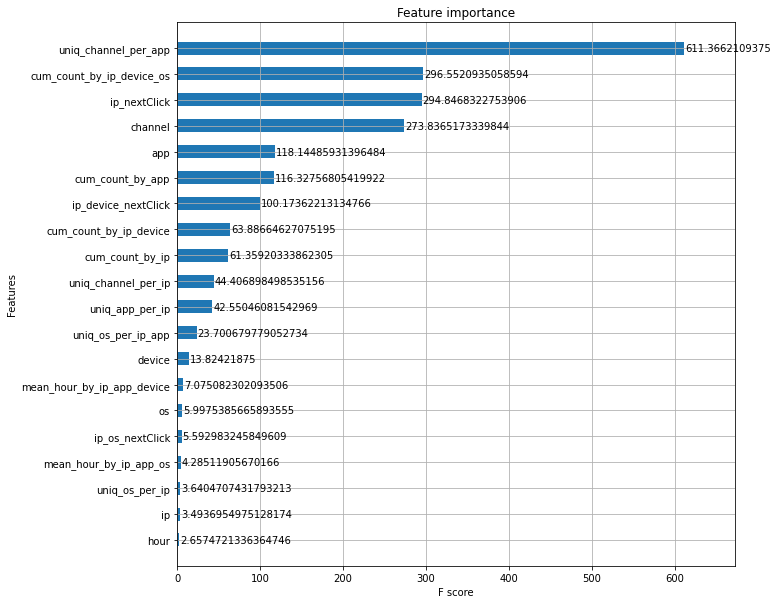

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(xgb_model, max_num_features = 20, height = 0.5, ax = ax,
                importance_type = "gain")
plt.show()

In [27]:
top_features = pd.DataFrame()
top_features['feature'] = X_train.columns
top_features['importance'] = xgb_model.feature_importances_
top_features.sort_values(by = 'importance', ascending=False, inplace=True)

top20_XGB_features = top_features[:20]
top20_XGB_features

feature  importance
31          ip_device_nextClick    0.304055
16         uniq_channel_per_app    0.237643
29                 ip_nextClick    0.178476
2                        device    0.070207
22             cum_count_by_app    0.039830
1                           app    0.038772
13            ip_channel_counts    0.021727
4                       channel    0.020085
30             ip_app_nextClick    0.015317
14              uniq_app_per_ip    0.012080
20       cum_count_by_ip_device    0.011649
21    cum_count_by_ip_device_os    0.010979
0                            ip    0.008143
19              cum_count_by_ip    0.006967
33  ip_device_channel_nextClick    0.006526
41            future_app_clicks    0.004871
3                            os    0.004234
43                  device_hour    0.001347
6                          hour    0.001082
42                    device_ip    0.000870

# Model Building

The following models will be evaluated for this classification problem:
1. Logistic Regression
2. K Nearest Neighbours (KNN)
3. Neural Network
4. Random Forest Classifier
5. XGBoost Classifier

In [34]:
#import relevant libraries
import pandas as pd

#Log Reg
from sklearn.linear_model import LogisticRegression

# Random forest classifier
from sklearn.ensemble import RandomForestClassifier

# SVM Classifier
from sklearn.svm import SVC

#Neural Network
from keras.models import Sequential
from keras.layers import Dense

#tuning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [35]:
from sklearn import metrics

def evaluation_metrics(y_actual, y_pred):
    # Confusion matrix
    print('Confusion matrix:\n', metrics.confusion_matrix(y_actual, y_pred), '\n')
    
    # Accuracy
    print('Accuracy:', metrics.accuracy_score(y_actual, y_pred), '\n')
    
    # Precision
    print('Precision:', metrics.precision_score(y_actual, y_pred), '\n')
    
    # Recall
    print('Recall:', metrics.recall_score(y_actual, y_pred))

In [36]:
xgb_featues = list(top20_XGB_features['feature'])

# NOTE: to be finalized
final_features = [
    # based on existing features
    'app', 'device', 'os', 'channel',
    
    # based on new features
    'uniq_app_per_ip', 'uniq_channel_per_ip', 'uniq_os_per_ip', 'uniq_channel_per_app', 'cum_count_by_app'
]

In [37]:
X_train_xgb = X_train.loc[:, xgb_featues]
X_train_final = X_train.loc[:, final_features]

### Logistic Regression

Baseline

In [12]:
lr = LogisticRegression(random_state=0, max_iter = 2000)

lr.fit(X_train_xgb_scaled, y_train)
y_train_pred_lr = lr.predict(X_train_xgb_scaled)

In [13]:
evaluation_metrics(y_train,y_train_pred_lr)

Confusion matrix:
 [[90100  3127]
 [ 5917 87310]] 

Accuracy: 0.9514947386486747 

Precision: 0.9654234439444033 

Recall: 0.9365312624025228


Tuned model

In [14]:
lr = LogisticRegression(random_state=0, max_iter=2000)
param_grid = {'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-2, 2, 5),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, n_jobs = -1)
clf_lr.fit(X_train_xgb_scaled,y_train)
print(clf_lr.best_estimator_)
print(clf_lr.best_params_)
print(clf_lr.best_score_)

LogisticRegression(C=100.0, max_iter=2000, random_state=0, solver='liblinear')
{'C': 100.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.9544177148811117


In [15]:
#check with no regularisation
lr_no_reg = LogisticRegression(random_state=0, max_iter=2000, penalty='none')
scores  = cross_val_score(lr_no_reg, X_train_xgb_scaled, y_train, cv=5)
print(np.mean(scores))

0.9544820732859082


In [16]:
#since cv without regularisation gives best cv score:
lr_tuned = LogisticRegression(random_state=0, max_iter=2000, penalty='none')

lr_tuned.fit(X_train_xgb_scaled, y_train)
y_train_pred_tunedlr = lr_tuned.predict(X_train_xgb_scaled)
evaluation_metrics(y_train,y_train_pred_tunedlr)

Confusion matrix:
 [[90204  3023]
 [ 5454 87773]] 

Accuracy: 0.9545357031761185 

Precision: 0.9667055817436891 

Recall: 0.9414976348053675


In [ ]:
#check on test data

### K Nearest Neighbours (KNN)

Baseline (default parameters)

In [4]:
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

In [64]:
#fit KNN classifier to the training set
knn= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  
knn.fit(X_train_xgb_scaled, y_train)
#predict the train set
y_pred= knn.predict(X_train_xgb_scaled)
#compute accuracy and recall score
print(f'Accuracy: {accuracy_score(y_train, y_pred)}\n')
_,recall,_,_ = precision_recall_fscore_support(y_train, y_pred)
print(f'Recall: {recall}')

Accuracy: 0.9855299430422517

Recall: [0.98683858 0.98422131]


Tune KNN model

In [65]:
#takes super long
estimator_KNN = KNeighborsClassifier(algorithm='auto') # ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.
parameters_KNN = {
    'n_neighbors': (1,10, 1), # Number of neighbors to use.
    'leaf_size': (20,40,1), # This can affect the speed of the construction and query, as well as the memory required to store the tree.
    'p': (1,2), # When p = 1, this is equivalent to using manhattan_distance, and euclidean_distance for p = 2.
    'weights': ('uniform', 'distance'), # 'uniform': uniform weights. All points in each neighborhood are weighted equally.
                                        #'distance': weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
    'metric': ('minkowski', 'chebyshev')}
                   
# with GridSearch
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    cv = 5
)

grid_search_KNN.fit(X_train_xgb_scaled,y_train)
print(grid_search_KNN.best_estimator_)
print(grid_search_KNN.best_params_)
print(grid_search_KNN.best_score_)

KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=1, weights='distance')
{'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
0.9809550885762969


In [67]:
#fit KNN classifier to the training set
knn_best= KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=1, weights='distance')  
knn_best.fit(X_train_xgb_scaled, y_train)
#predict the train set
y_pred= knn_best.predict(X_train_xgb_scaled)
#compute accuracy and recall score
print(f'Accuracy: {accuracy_score(y_train, y_pred)}\n')
_,recall,_,_ = precision_recall_fscore_support(y_train, y_pred)
print(f'Recall: {recall}')

Accuracy: 1.0

Recall: [1. 1.]


Probably overfitting, need to verify with the testing set

### Neural Network - Grid Search

Choosing model based on CV score

In [156]:
def create_model(optimizer, activation, nl, nn):
    model = Sequential()
    #1st hidden layer
    model.add(Dense(nn, input_shape=(16,), activation=activation))

    #remaining hidden layers
    for i in range(1, nl):
        model.add(Dense(nn, activation=activation))
    
    #output (binary)
    model.add(Dense(1, activation="sigmoid"))

    #compile
    model.compile(optimizer=optimizer, loss="binary_crossentropy")

    return model

In [162]:
#Turn keras model to sklearn estimator
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(model=create_model, activation="adam", nl=1, nn=1)

In [165]:
activation = ["relu", "sigmoid", "tanh"]
optimizer = ["adam", "SGD", "RMSprop"]
nl = [1,2,3,4,5,6,7,8,9,10]
nn = [1,2,3,4,5,6,7,8,9,10]

param = {
    "optimizer": optimizer,
    "activation": activation,
    "nl": nl,
    "nn": nn
}

nn_random_search = RandomizedSearchCV(model, param, cv=3)
nn_random_search.fit(X_train_xgb_scaled, y_train, verbose=0)


1943/1943 [==============================] - 8s 4ms/step


RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(activation='adam', model=<function create_model at 0x000002BB19B29280>, nl=1, nn=1),
                   param_distributions={'activation': ['relu', 'sigmoid',
                                                       'tanh'],
                                        'nl': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                        'nn': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                        'optimizer': ['adam', 'SGD',
                                                      'RMSprop']})

In [166]:
print(nn_random_search.best_estimator_)
print(nn_random_search.best_params_)
print(nn_random_search.best_score_)

KerasClassifier(
	model=<function create_model at 0x000002BB19B29280>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	activation=relu
	nl=6
	nn=7
	class_weight=None
)
{'optimizer': 'adam', 'nn': 7, 'nl': 6, 'activation': 'relu'}
0.9559301503693246


In [27]:
#fit with best model

best_nn = Sequential()
#1st hidden layer
best_nn.add(Dense(7, input_shape=(16,), activation="relu"))
#remaining hidden layers
for i in range(1, 6):
    best_nn.add(Dense(7, activation="relu"))
#output (binary)
best_nn.add(Dense(1, activation="sigmoid"))
#compile
best_nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [29]:
best_nn.fit(X_train_xgb_scaled, y_train)

5827/5827 [==============================] - 38s 6ms/step - loss: 0.1636 - accuracy: 0.9400


In [30]:
#training loss and accuracy
best_nn.evaluate(X_train_xgb_scaled, y_train)

5827/5827 [==============================] - 28s 5ms/step - loss: 0.1228 - accuracy: 0.9564


[0.12276649475097656, 0.956396758556366]

### Neural Network - Bayesian Optimization

In [12]:
# ignore warning to clean up the results
import warnings
warnings.filterwarnings("ignore")

In [32]:
#pip install git+https://github.com/fmfn/BayesianOptimization

  Running command git clone -q https://github.com/fmfn/BayesianOptimization 'C:\Users\vanes\AppData\Local\Temp\pip-req-build-6a91jy9i'



  Cloning https://github.com/fmfn/BayesianOptimization to c:\users\vanes\appdata\local\temp\pip-req-build-6a91jy9i
  Resolved https://github.com/fmfn/BayesianOptimization to commit 05941f75134165506eeb750fb5fc94f4d5668d5c
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.3.0-py3-none-any.whl size=16866 sha256=8492c6da63eef98e8e2756859d8a1754c604a975464a2f6dac4715762feb02f3
  Stored in directory: C:\Users\vanes\AppData\Local\Temp\pip-ephem-wheel-cache-1xg5gndx\wheels\de\4b\fc\ca63ecde7529784254ce89a4c60adafcb973a6b20aa9f18dd4
Successfully built bayesian-optimization


In [13]:
from bayes_opt import BayesianOptimization # Bayesian optimization is more efficient in time and memory capacity for tuning many hyperparameters
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
LeakyReLU = LeakyReLU(alpha=0.1)
score_acc = make_scorer(accuracy_score)

Tune hyperparameters of the model (without layer)

In [18]:
# Create function
def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs ):
    # optimizer
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl', 'SGD']
    optimizerD= {'SGD':SGD(learning_rate=learning_rate), 'Adam':Adam(learning_rate=learning_rate), 
                 'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
                 'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
                 'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
    # activation function
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU, 'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    def nn_cl_fun():
        opt = Adam(learning_rate = learning_rate)
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=16, activation=activation))
        nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20) # EarlyStopping is used to stop the learning process if there is no accuracy improvement in 20 epochs
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,
                         verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(nn, X_train_xgb_scaled, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [19]:
# Set paramaters
params_nn ={
    'neurons': (1, 16),
    'activation':(0, 9),
    'optimizer':(0,8),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=111)
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  epochs   | learni... |  neurons  | optimizer |
-------------------------------------------------------------------------------------------------
1166/1166 [==============================] - 2s 1ms/step
| 1         | 0.5592    | 5.51      | 335.3     | 54.88     | 0.7716    | 5.43      | 1.193     |
1166/1166 [==============================] - 2s 1ms/step
| 2         | 0.7886    | 0.2023    | 536.2     | 39.09     | 0.3443    | 15.86     | 1.902     |
1166/1166 [==============================] - 2s 2ms/step
| 3         | 0.9795    | 0.7307    | 735.7     | 69.7      | 0.2815    | 7.993     | 0.9469    |
1166/1166 [==============================] - 2s 1ms/step
| 4         | 0.8603    | 0.6656    | 920.6     | 83.52     | 0.8422    | 13.23     | 7.928     |
1166/1166 [==============================] - 1s 886us/step
| 5         | 0.9835    | 5.195     | 851.0     | 53.71     | 0.03717   | 7.812     | 0.8426    |
1166/1166 [================

1166/1166 [==============================] - 2s 1ms/step
| 19        | 0.9742    | 0.8254    | 703.8     | 92.23     | 0.3464    | 10.79     | 7.401     |
1166/1166 [==============================] - 2s 1ms/step
| 20        | 0.9596    | 3.366     | 817.1     | 91.69     | 0.624     | 3.266     | 2.999     |
1166/1166 [==============================] - 2s 1ms/step
| 21        | 0.6407    | 5.723     | 567.3     | 62.58     | 0.3588    | 10.9      | 3.812     |
1166/1166 [==============================] - 2s 1ms/step
| 22        | 0.9273    | 4.091     | 299.8     | 53.0      | 0.2804    | 6.201     | 7.795     |
1166/1166 [==============================] - 2s 2ms/step
| 23        | 0.7463    | 1.94      | 746.3     | 22.54     | 0.837     | 11.52     | 7.728     |
1166/1166 [==============================] - 2s 1ms/step
| 24        | 0.9844    | 5.326     | 373.9     | 77.54     | 0.04056   | 7.281     | 2.25      |
1166/1166 [==============================] - 1s 899us/step
| 25       

In [21]:
params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU]
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
optimizerD= {'SGD':SGD(learning_rate=learning_rate), 'Adam':Adam(learning_rate=learning_rate), 
             'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
             'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
             'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
params_nn_

{'activation': 'sigmoid',
 'batch_size': 541,
 'epochs': 87,
 'learning_rate': 0.11930722873107395,
 'neurons': 16,
 'optimizer': <keras.optimizers.optimizer_v2.rmsprop.RMSprop at 0x14d1ea01240>}

In [22]:
score = nn_cl_bo(**nn_bo.max['params'])
print(f'Cross validation score: {score}')

1166/1166 [==============================] - 1s 997us/step
Cross validation score: 0.9879219447917393


Tune hyperparameters of the model (with layer)

In [23]:
# Create function (consider layer)
def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate):
    # optimizer
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl', 'SGD']
    optimizerD= {'SGD':SGD(learning_rate=learning_rate), 'Adam':Adam(learning_rate=learning_rate), 
                 'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
                 'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
                 'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
    # activation function
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU, 'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=16, activation=activation))
        if normalization > 0.5:
            nn.add(BatchNormalization()) # It serves to speed up training and use higher learning rates
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation))
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=1))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20) # EarlyStopping is used to stop the learning process if there is no accuracy improvement in 20 epochs
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    score = cross_val_score(nn, X_train_xgb_scaled, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [24]:
# Set paramaters (consider layer)
params_nn2 ={
    'neurons': (1, 16),
    'activation':(0, 9),
    'optimizer':(0,8),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100),
    'layers1':(1,5),
    'layers2':(1,5),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}
# Run Bayesian Optimization
nn_bo2 = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=111)
nn_bo2.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
1166/1166 [==============================] - 2s 1ms/step
| 1         | 0.971     | 5.51      | 335.3     | 0.4361    | 0.2308    | 43.63     | 1.597     | 1.09      | 0.426     | 4.58      | 0.3377    | 7.926     |
1166/1166 [==============================] - 2s 2ms/step
| 2         | 0.5       | 2.14      | 265.0     | 0.6696    | 0.1864    | 41.94     | 2.865     | 1.473     | 0.08322   | 14.51     | 0.794     | 6.725     |
1166/1166 [==============================] - 1s 1ms/step
| 3         | 0.5       | 7.337     | 992.8     | 0.5773    | 0.2441    | 53.71     | 1.11      | 2.817     | 0.1143    | 13.26     | 0.6977    | 4.522     |
1166/1166 [============================

In [25]:
params_nn_2 = nn_bo2.max['params']
learning_rate2 = params_nn_2['learning_rate']
activationL2 = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU]
params_nn_2['activation'] = activationL[round(params_nn_2['activation'])]
params_nn_2['batch_size'] = round(params_nn_2['batch_size'])
params_nn_2['epochs'] = round(params_nn_2['epochs'])
params_nn_2['layers1'] = round(params_nn_2['layers1'])
params_nn_2['layers2'] = round(params_nn_2['layers2'])
params_nn_2['neurons'] = round(params_nn_2['neurons'])
optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
optimizerD= {'SGD':SGD(learning_rate=learning_rate2), 'Adam':Adam(learning_rate=learning_rate2), 
             'RMSprop':RMSprop(learning_rate=learning_rate2), 'Adadelta':Adadelta(learning_rate=learning_rate2),
             'Adagrad':Adagrad(learning_rate=learning_rate2), 'Adamax':Adamax(learning_rate=learning_rate2),
             'Nadam':Nadam(learning_rate=learning_rate2), 'Ftrl':Ftrl(learning_rate=learning_rate2)}
params_nn_2['optimizer'] = optimizerD[optimizerL[round(params_nn_2['optimizer'])]]
params_nn_2

{'activation': 'softplus',
 'batch_size': 921,
 'dropout': 0.8182638736220813,
 'dropout_rate': 0.11976995858293202,
 'epochs': 86,
 'layers1': 2,
 'layers2': 3,
 'learning_rate': 0.4183500837466161,
 'neurons': 15,
 'normalization': 0.8253804525121795,
 'optimizer': <keras.optimizers.optimizer_v2.adagrad.Adagrad at 0x14d1c1bfd60>}

In [26]:
score2 = nn_cl_bo2(**nn_bo2.max['params'])
print(f'Cross validation score: {score2}')

1166/1166 [==============================] - 2s 1ms/step
Cross validation score: 0.9908342079854815


### Random Forest Classifier

In [13]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train_xgb, y_train)
y_pred_train_rfc = rfc.predict(X_train_xgb)

In [14]:
evaluation_metrics(y_train, y_pred_train_rfc)

Confusion matrix:
 [[93227     0]
 [    0 93227]] 

Accuracy: 1.0 

Precision: 1.0 

Recall: 1.0


In [15]:
# Check parameters because model is likely to be overfitting
print('Parameters currently in use:\n')
print(rfc.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [37]:
# Tuning
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [38]:
# Use random grid to search for best hyperparameters
# Random search of parameters, using 5 fold cross validation, 
# search across 10 different combinations, and use all available cores
rfc_search = RandomizedSearchCV(estimator = rfc, 
                               param_distributions = random_grid, 
                               n_iter = 10, 
                               cv = 5, 
                               verbose = 3, 
                               random_state = 0, 
                               n_jobs = -1)

In [ ]:
# Fit the random search model
rfc_search.fit(X_train_xgb, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
print(rfc_search.best_estimator_)
print(rfc_search.best_params_)
print(rfc_search.best_score_)

In [ ]:
# fit best RandomForestClassifier on training set
rfc_best = RandomForestClassifier(bootstrap=False, max_depth=40, min_samples_leaf=2,
                       n_estimators=600, random_state=0)

rfc_best.fit(X_train_xgb, y_train)
y_pred_rfc_best = rfc_best.predict(X_train_xgb)

In [ ]:
evaluation_metrics(y_train, y_pred_rfc_best)

### XGBoost

In [38]:
# using default parameters for xgb features
xgb = XGBClassifier(random_state = 0)
xgb.fit(X_train_xgb, Y_train)
Y_pred_xgb = xgb.predict(X_train_xgb)

In [39]:
evaluation_metrics(Y_train, Y_pred_xgb)

Confusion matrix:
 [[93217    10]
 [    0 93227]] 

Accuracy: 0.9999463674686517 

Precision: 0.9998927464418632 

Recall: 1.0


In [40]:
# perform grid search for xgb features
xgb = XGBClassifier(random_state = 0)
param_grid = {'eta' : [0.1, 0.2, 0.3],
              'lambda' : [0, 0.5, 1.0],
              'alpha' : [0, 0.5, 1.0],}

xgb_best = GridSearchCV(xgb, param_grid = param_grid, cv = 5, n_jobs = -1)

In [41]:
# using xgb features
xgb_best.fit(X_train_xgb, Y_train)
print(xgb_best.best_estimator_)
print(xgb_best.best_params_)
print(xgb_best.best_score_)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', lambda=0,
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)
{'alpha': 0, 'eta': 0.3, 'lambda': 0}
0.9991633319643375


In [42]:
# using default parameters for final features
xgb = XGBClassifier(random_state = 0)
xgb.fit(X_train_final, Y_train)
Y_pred_final = xgb.predict(X_train_final)

In [43]:
evaluation_metrics(Y_train, Y_pred_final)

Confusion matrix:
 [[93217    10]
 [    3 93224]] 

Accuracy: 0.9999302777092474 

Precision: 0.9998927429907545 

Recall: 0.999967820481191


In [44]:
# perform grid search for final features
xgb_best.fit(X_train_final, Y_train)
print(xgb_best.best_estimator_)
print(xgb_best.best_params_)
print(xgb_best.best_score_)

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', lambda=0.5,
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)
{'alpha': 0.5, 'eta': 0.3, 'lambda': 0.5}
0.9992062384784252


In [46]:
# using best set of parameters for final features
xgb = XGBClassifier(random_state = 0,
                   reg_alpha = 0.5, eta = 0.3, reg_lambda = 0.50)
xgb.fit(X_train_final, Y_train)
Y_pred_final = xgb.predict(X_train_final)

In [47]:
evaluation_metrics(Y_train, Y_pred_final)

Confusion matrix:
 [[93216    11]
 [    1 93226]] 

Accuracy: 0.9999356409623822 

Precision: 0.9998820210860495 

Recall: 0.9999892734937303


## Prepare Testing Set

In [10]:
import pandas as pd
test = pd.read_csv('./test_sampled.csv')

In [ ]:
test.head()

In [3]:
test_processed = pd.read_csv('./test_processed.csv')

In [7]:
test_processed.head()

ip  app  device  os  channel           click_time  is_attributed  day  \
0   18839   15       1  32      430  2017-11-09 03:29:07              0    9   
1  198976    3       1  19      480  2017-11-08 05:42:59              0    8   
2  186326   18       1  25      107  2017-11-07 02:56:34              0    7   
3   21960   18       1   1      121  2017-11-07 09:45:50              0    7   
4   71447    9       1  14      244  2017-11-09 12:32:14              0    9   

   hour  minute  ...  var_day_by_ip_app_device  prev_identical_clicks  \
0     3      29  ...                  0.959025                      0   
1     5      42  ...                  0.694902                      0   
2     2      56  ...                  0.916667                      0   
3     9      45  ...                  0.894831                      0   
4    12      32  ...                  0.111111                      0   

   future_identical_clicks  prev_app_clicks  future_app_clicks  device_ip  \
0                        0                0                 42     118839   
1                        0                0                 50    1198976   
2                        0                0                 16    1186326   
3                        0                0                 33     121960   
4                        0                0                  8     171447   

   ip_nextClick  ip_app_nextClick  ip_device_nextClick  device_hour  
0       31945.0           26242.0              31945.0           13  
1       38780.0           21921.0              38780.0           15  
2       14807.0            6466.0              14807.0           12  
3         373.0           10809.0                373.0           19  
4       40571.0            1946.0              40571.0          112  

[5 rows x 46 columns]

### Create new features for testing set

In [11]:
# day, hour, minute, second, dayOfWeek
test_datetime = pd.to_datetime(test['click_time'], format='%Y-%m-%d %H:%M:%S')
test['click_time'] = test_datetime
test['day'] = test_datetime.dt.day
test['hour'] = test_datetime.dt.hour
test['minute'] = test_datetime.dt.minute
test['second'] = test_datetime.dt.second
test["dayOfWeek"] = test_datetime.dt.weekday

In [8]:
#total counts
test = agg_counts(test, ["ip", "app", "device", "os", "channel"], 'ip_app_dev_os_cha_counts')
test = agg_counts(test, ["ip", "app", "device", "os"], 'ip_app_dev_os_counts')
test = agg_counts(test, ["ip", "app", "device"], 'ip_app_dev_counts')
# test = agg_counts(test, ["ip", "app", "os"], 'ip_app_os_counts')
test = agg_counts(test, ["ip", "app", "hour"], 'ip_app_hour_counts')
test = agg_counts(test, ["ip", "channel"], 'ip_channel_counts')
# test = agg_counts(test, ["ip", "app"], 'ip_app_counts')
# test = agg_counts(test, ["ip", "day"], 'ip_per_day')
# test = agg_counts(test, ["ip"], "ip_counts")

In [9]:
#unique counts
test = agg_unique(test, ["ip"], "app", "uniq_app_per_ip")
# test = agg_unique(test, ["ip"], "device", "uniq_device_per_ip")
# test = agg_unique(test, ["ip"], "channel", "uniq_channel_per_ip")
# test = agg_unique(test, ["ip"], "os", "uniq_os_per_ip")
test = agg_unique(test, ["ip", "device", "os"], "app", "uniq_app_per_ip_dev_os")
test = agg_unique(test, ["app"], "channel", "uniq_channel_per_app")
test = agg_unique(test, ["ip", "day"], "hour", "uniq_hour_per_ip_day")
test = agg_unique(test, ["ip", "app"], "os", "uniq_os_per_ip_app")

In [10]:
#cumulative counts
test = agg_cum_count(test, ["ip"], "cum_count_by_ip")
test = agg_cum_count(test, ["ip", "device"], "cum_count_by_ip_device")
test = agg_cum_count(test, ["ip", "device","os"], "cum_count_by_ip_device_os")
# test = agg_cum_count(test, ["ip", "device","os","channel"], "cum_count_by_ip_device_os_channel")
# test = agg_cum_count(test, ["ip", "device","os","channel","app"], "cum_count_by_ip_device_os_channel_app")
test = agg_cum_count(test, ["app"], "cum_count_by_app")
# test = agg_cum_count(test, ["ip", "app"], "cum_count_by_ip_app")

In [11]:
#variance
test = agg_var(test, ["ip","app","channel"], "hour", "var_hour_by_ip_app_channel")
test = agg_var(test, ["ip","app","os"], "hour", "var_hour_by_ip_app_os")
test = agg_var(test, ["ip","app","device"], "hour", "var_hour_by_ip_app_device")
test = agg_var(test, ["ip","app","channel"], "dayOfWeek", "var_day_by_ip_app_channel")
test = agg_var(test, ["ip","app","os"], "dayOfWeek", "var_day_by_ip_app_os")
test = agg_var(test, ["ip","app","device"], "dayOfWeek", "var_day_by_ip_app_device")

In [12]:
#mean
# test = agg_mean(test, ["ip","app","channel"], "hour", "mean_hour_by_ip_app_channel")
# test = agg_mean(test, ["ip","app","os"], "hour", "mean_hour_by_ip_app_os")
# test = agg_mean(test, ["ip","app","device"], "hour", "mean_hour_by_ip_app_device")

In [12]:
# time till next click
GROUP_BY_NEXT_CLICKS = [
    
    # ip with one other feature
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'device']},
    # {'groupby': ['ip', 'os']},
    # {'groupby': ['ip', 'channel']},
    
    
    # ip with two other features
    # {'groupby': ['ip', 'app', 'device']},
    # {'groupby': ['ip', 'app', 'os']},
    # {'groupby': ['ip', 'app', 'channel']},
    {'groupby': ['ip', 'device', 'os']},
    {'groupby': ['ip', 'device', 'channel']},
    # {'groupby': ['ip', 'os', 'channel']},

    # ip with three other features
    {'groupby': ['ip', 'app', 'device', 'os']},
    {'groupby': ['ip', 'app', 'device', 'channel']},
    {'groupby': ['ip', 'device', 'os', 'channel']},

    # ip with all other features
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']}
]

# Calculate the time to next click for each group
for spec in GROUP_BY_NEXT_CLICKS:
    
    # Name of new feature
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    # Run calculation
    print(f">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    test[new_feature] = test[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds

>> Grouping by ['ip', 'app', 'device', 'os'], and saving time to next click in: ip_app_device_os_nextClick
>> Grouping by ['ip', 'app', 'device', 'channel'], and saving time to next click in: ip_app_device_channel_nextClick
>> Grouping by ['ip', 'device', 'os', 'channel'], and saving time to next click in: ip_device_os_channel_nextClick
>> Grouping by ['ip', 'app', 'device', 'os', 'channel'], and saving time to next click in: ip_app_device_os_channel_nextClick


In [13]:
# clicks on app ad before & after
HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

# Go through different group-by combinations
for fname, fset in HISTORY_CLICKS.items():
    
    # Clicks in the past
    test['prev_'+fname] = test.groupby(fset).cumcount().rename('prev_'+fname)
        
    # Clicks in the future
    test['future_'+fname] = test.iloc[::-1].groupby(fset).cumcount().rename('future_'+fname).iloc[::-1]

In [52]:
# combining device & ip
test['device_ip'] = test['device'].map(str) + test['ip'].map(str)
# combining device & hour
test['device_hour'] = test['device'].map(str) + test['hour'].map(str)

In [3]:
# dealing with NaN values
data=test_processed

In [4]:
checkna = [data[var].isnull().sum() for var in data.columns]
na_df = pd.DataFrame({"Variable": data.columns, "Number of Missing Values": checkna})

In [5]:
na_df[na_df["Number of Missing Values"] > 0]

Variable  Number of Missing Values
12          ip_app_device_os_nextClick                   4502316
13     ip_app_device_channel_nextClick                   3540794
14      ip_device_os_channel_nextClick                   6116842
15  ip_app_device_os_channel_nextClick                   6689245
16             ip_app_device_nextClick                   1392886
17                 ip_app_os_nextClick                   4385171
18            ip_app_channel_nextClick                   3413362
19              ip_device_os_nextClick                   1400370
20         ip_device_channel_nextClick                   2725982
21             ip_os_channel_nextClick                   6010855
46          var_hour_by_ip_app_channel                   1982324
47               var_hour_by_ip_app_os                   2993273
48           var_hour_by_ip_app_device                    614315
49           var_day_by_ip_app_channel                   1982324
50                var_day_by_ip_app_os                   2993273
51            var_day_by_ip_app_device                    614315
60                        ip_nextClick                    149323
61                    ip_app_nextClick                   1293098
62                 ip_device_nextClick                    228239
63                     ip_os_nextClick                   1320080
64                ip_channel_nextClick                   2593199

In [6]:
data.fillna(0, inplace=True)

In [7]:
checkna1 = [data[var].isnull().sum() for var in data.columns]
na_df1 = pd.DataFrame({"Variable": data.columns, "Number of Missing Values": checkna1})
len(na_df1[na_df1["Number of Missing Values"] > 0])

0

In [9]:
test_processed.to_csv('./test_processed.csv', index=False)

### Drop highly-correlated features

In [5]:
test_processed = test_processed.drop(labels = ['cum_count_by_ip_app', 'cum_count_by_ip_device_os_channel_app', 'ip_counts', 'dayOfWeek'], axis = 1)

Additionally, we also decided to drop one of the features for feature pairs that have high correlation as they will have almost the same effect on the dependent variable. 

In [6]:
test_processed = test_processed.drop(labels = ['uniq_os_per_ip', 'uniq_channel_per_ip', 'mean_hour_by_ip_app_os', 'ip_per_day',
                            'cum_count_by_ip_device_os_channel', 'uniq_device_per_ip', 'mean_hour_by_ip_app_channel', 
                            'ip_os_nextClick', 'ip_app_os_counts', 'ip_os_channel_nextClick', 'mean_hour_by_ip_app_device', 
                             'ip_channel_nextClick', 'ip_app_counts', 'ip_app_device_nextClick', 'ip_app_os_nextClick', 'ip_app_channel_nextClick'], axis = 1)

### Encode categorical variables

In [35]:
# encoding test set, unknown categories are filled with 0
categorical_features = ['ip', 'app', 'device', 'os', 'channel', 'device_ip', 'device_hour']
new_test_cat = count_enc.transform(test_processed[categorical_features])

In [37]:
# replacing original columns with data
test_processed[categorical_features] = new_test_cat
test_processed.head()

ip       app    device        os   channel           click_time  \
0  0.000059  0.046462  0.805866  0.012588  0.001824  2017-11-09 03:29:07   
1  0.000016  0.101864  0.805866  0.206887  0.007825  2017-11-08 05:42:59   
2  0.000011  0.052136  0.805866  0.016481  0.028012  2017-11-07 02:56:34   
3  0.000064  0.052136  0.805866  0.008587  0.015328  2017-11-07 09:45:50   
4  0.000005  0.065609  0.805866  0.011322  0.005755  2017-11-09 12:32:14   

   is_attributed  day  hour  minute  ...  var_day_by_ip_app_device  \
0              0    9     3      29  ...                  0.959025   
1              0    8     5      42  ...                  0.694902   
2              0    7     2      56  ...                  0.916667   
3              0    7     9      45  ...                  0.894831   
4              0    9    12      32  ...                  0.111111   

   prev_identical_clicks  future_identical_clicks  prev_app_clicks  \
0                      0                        0                0   
1                      0                        0                0   
2                      0                        0                0   
3                      0                        0                0   
4                      0                        0                0   

   future_app_clicks  device_ip  ip_nextClick  ip_app_nextClick  \
0                 42   0.000059       31945.0           26242.0   
1                 50   0.000011       38780.0           21921.0   
2                 16   0.000011       14807.0            6466.0   
3                 33   0.000064         373.0           10809.0   
4                  8   0.000005       40571.0            1946.0   

   ip_device_nextClick  device_hour  
0              31945.0     0.056464  
1              38780.0     0.051535  
2              14807.0     0.056421  
3                373.0     0.040364  
4              40571.0     0.040310  

[5 rows x 46 columns]

In [38]:
test_processed.to_csv('./test_encoded.csv', index=False)